In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import glob
import itertools

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from tqdm import tqdm
import xgboost as xgb #BDT
import pickle
import yahist
import mplhep as hep

import concurrent.futures as futures

from utils.analysis import Validation, PandasAnalysis

TAG = "abcdnet_v6"
PLOTSDIR = f"/home/users/jguiang/public_html/vbsvvhjets_plots/{TAG}/val"

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Before Preselection

In [2]:
babies = sorted(glob.glob(f"../analysis/studies/vbsvvhjets/output_{TAG}/Run2/*.root"))
sig_babies = [baby for baby in babies if "VBSVVH" in baby]
bkg_babies = [baby for baby in babies if "VBS" not in baby and "data" not in baby]
data_babies = [baby for baby in babies if "data" in baby]
print("Signal:")
print("\n".join(sig_babies))
print("Background:")
print("\n".join(bkg_babies))
print("Data:")
print("\n".join(data_babies))

Signal:

Background:

Data:



In [3]:
vbsvvh = Validation(
    sig_root_files=sig_babies,
    bkg_root_files=bkg_babies,
    data_root_files=data_babies,
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", 
        "pu_sf", 
        "prefire_sf"
    ],
    plots_dir=PLOTSDIR,
    sample_labels = {
        "VBSVVH": r"VBS VVH $(C_{2V} = 2)$", 
        "TTHad": r"$t\bar{t}+$jets",
        "TT1L": r"$t\bar{t}+1\ell$",
        "QCD": "QCD",
        "SingleTop": r"Single $t$",
        "TTH": r"$t\bar{t}+H$",
        "TTW": r"$t\bar{t}+W$",
    },
)

vbsvvh.df["objsel"] = True
vbsvvh.df["presel"] = vbsvvh.df.eval(
    "objsel and hbbfatjet_xbb > 0.5 and ld_vqqfatjet_xwqq > 0.3 and tr_vqqfatjet_xwqq > 0.3"
)

bkg_count = vbsvvh.bkg_count()
qcd_count = vbsvvh.sample_count("QCD")
data_count = vbsvvh.data_count()

vbsvvh.df.loc[(vbsvvh.df.name == "QCD"), "event_weight"] *= (data_count - (bkg_count - qcd_count))/(qcd_count)

Loading data babies: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.93s/it]


In [4]:
(data_count - (bkg_count - qcd_count))/(qcd_count)

1.229329258312229

In [4]:
history = {}

def plot_many(plot_tuples, sel="objsel", norm=False, sig_scale=0, year=None, 
              hist_ylim=[None, None], ratio_ylim=[0, 2], xlim=[None, None],
              logy=False):
    if year:
        sel = f"{sel} and abs(year) == {year}"
    for var, bins, label in plot_tuples:
        if year:
            if year == 2016:
                vbsvvh.lumi = 36.33
            elif year == 2017:
                vbsvvh.lumi = 41.48
            elif year == 2018:
                vbsvvh.lumi = 59.83
        
        plot_hash = hash((var, sel, norm, year))
        plot_subhash = hash((",".join(bins.astype(str)), sig_scale, label, logy))
        if history.get(plot_hash, None) != plot_subhash:
            hist_axes, ratio_axes = vbsvvh.plot_data_vs_mc(
                var, bins, selection=sel, norm=norm, x_label=label, sig_scale=sig_scale, stacked=True, logy=logy
            )
            history[plot_hash] = plot_subhash
            
            # Custom legend position
            hist_axes.legend(fontsize=14, loc="upper right", ncol=2)
            # Set hist y range
            bottom, top = hist_ylim
            if not top is None:
                hist_axes.set_ylim(top=top)
            if not bottom is None:
                hist_axes.set_ylim(bottom=bottom)
            # Set ratio y range
            bottom, top = ratio_ylim
            if not top is None:
                ratio_axes.set_ylim(top=top)
            if not bottom is None:
                ratio_axes.set_ylim(bottom=bottom)
            # Set x range
            left, right = xlim
            if not left is None:
                hist_axes.set_xlim(left=left)
                ratio_axes.set_xlim(left=left)
            if not right is None:
                hist_axes.set_xlim(right=right)
                ratio_axes.set_xlim(right=right)
                
            # Overwrite plot
            plot_file = f"{PLOTSDIR}/{var}_data_vs_mc.pdf"
            if norm:
                plot_file = plot_file.replace(".pdf", "_norm.pdf")
            if logy:
                plot_file = plot_file.replace(".pdf", "_log.pdf")
            if sel:
                plot_file = plot_file.replace(".pdf", f"_{PandasAnalysis.get_selection_str(sel)}.pdf")

            print(f"Wrote plot to {plot_file} :)")
            plt.savefig(plot_file, bbox_inches="tight")
            plt.savefig(plot_file.replace(".pdf", ".png"), bbox_inches="tight")
                
        else:
            print("This plot has already been plotted during the runtime of this kernel")
            
        if year:
            vbsvvh.lumi = 138

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/hbbfatjet_xbb_data_vs_mc_log_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/hbbfatjet_xbb_data_vs_mc_log_objsel.pdf :)
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/ld_vqqfatjet_xwqq_data_vs_mc_log_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/ld_vqqfatjet_xwqq_data_vs_mc_log_objsel.pdf :)
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/tr_vqqfatjet_xwqq_data_vs_mc_log_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/tr_vqqfatjet_xwqq_data_vs_mc_log_objsel.pdf :)


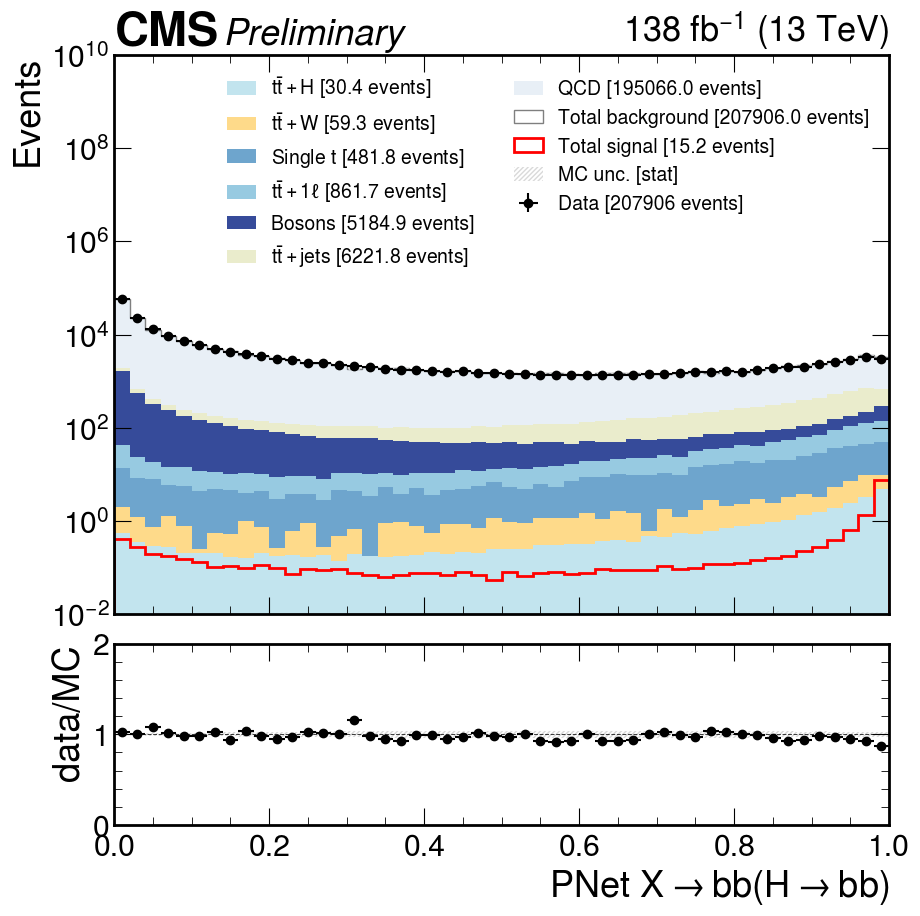

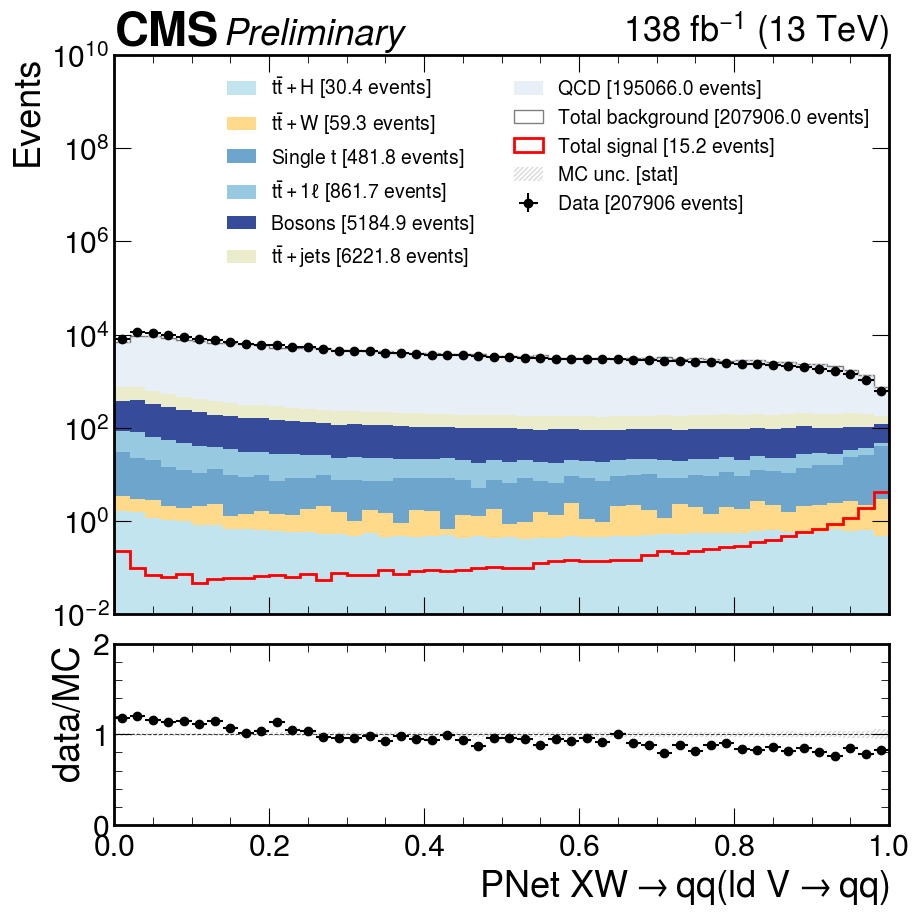

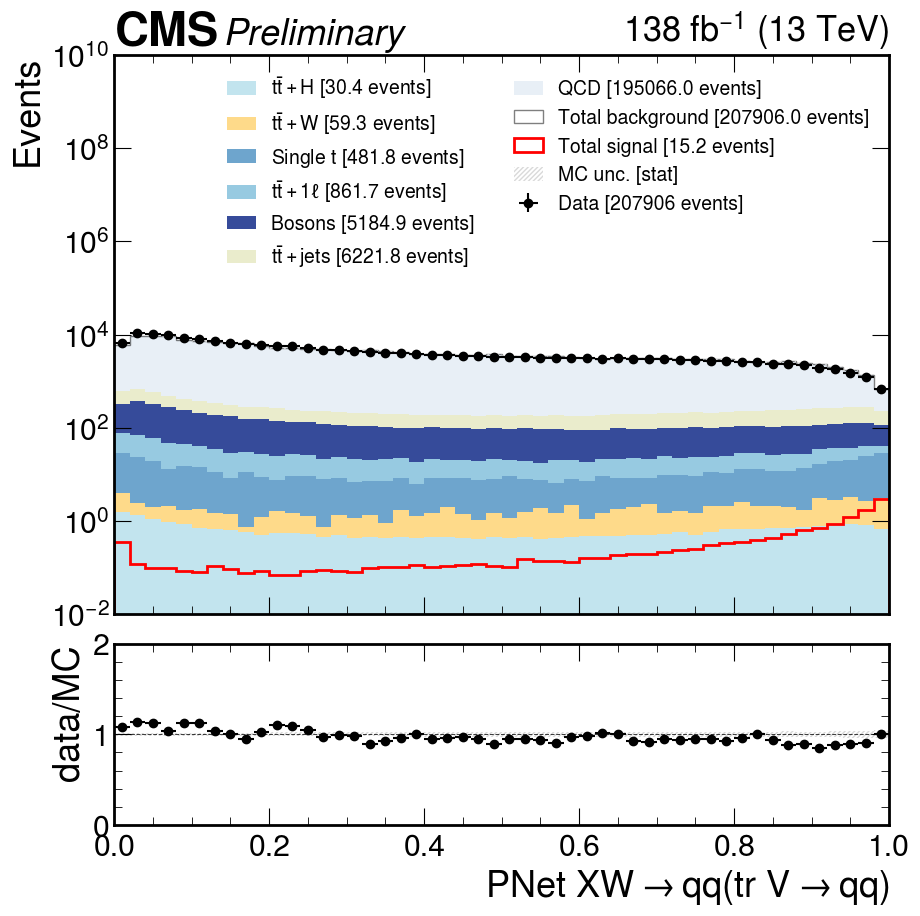

In [5]:
nbins = 50

plot_many(
    [
        # Fat jet ParticleNet score
        ("hbbfatjet_xbb", np.linspace(0, 1, nbins+1), r"PNet $X\rightarrow bb(H\rightarrow bb)$"),
        ("ld_vqqfatjet_xwqq", np.linspace(0, 1, nbins+1), r"PNet $XW\rightarrow qq($ld $V\rightarrow qq)$"),
        ("tr_vqqfatjet_xwqq", np.linspace(0, 1, nbins+1), r"PNet $XW\rightarrow qq($tr $V\rightarrow qq)$"),
    ],
    sel="objsel",
    norm=False,
    sig_scale=1,
    logy=True,
    hist_ylim=[1e-2, 1e10]
)

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/ST_data_vs_mc_log_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/ST_data_vs_mc_log_objsel.pdf :)
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/HT_data_vs_mc_log_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/HT_data_vs_mc_log_objsel.pdf :)
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/HT_fat_data_vs_mc_log_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/HT_fat_data_vs_mc_log_objsel.pdf :)
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/MET_data_vs_mc_log_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/MET_data_vs_mc_log_objsel.pdf :)
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/n_jets_data_vs_mc_log_objsel.pdf
Wrote plot 

/home/users/jguiang/projects/vbs/notebooks/utils/analysis.py:891: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/ld_vqqfatjet_pt_data_vs_mc_log_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/ld_vqqfatjet_pt_data_vs_mc_log_objsel.pdf :)
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/tr_vqqfatjet_pt_data_vs_mc_log_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/tr_vqqfatjet_pt_data_vs_mc_log_objsel.pdf :)
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/hbbfatjet_eta_data_vs_mc_log_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/hbbfatjet_eta_data_vs_mc_log_objsel.pdf :)
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/ld_vqqfatjet_eta_data_vs_mc_log_objsel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/ld_vqqfatjet_eta_data_vs_mc_log_objsel.pdf :)
Wrote plot to /home/users/jgui

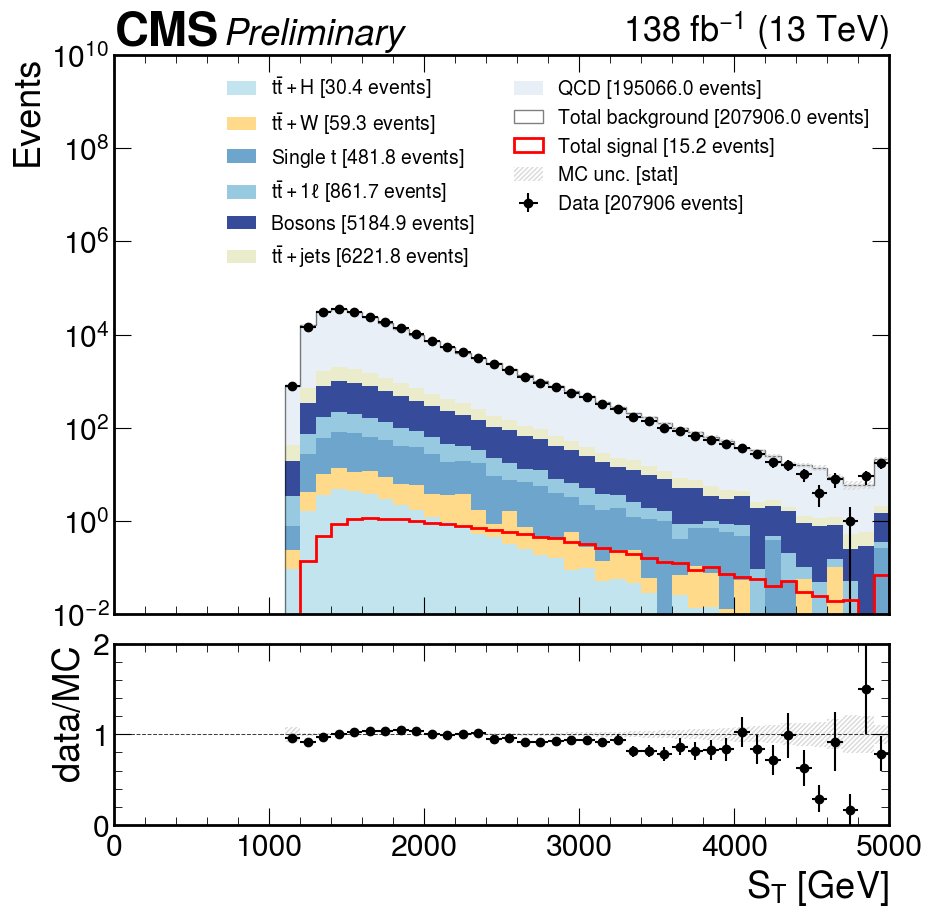

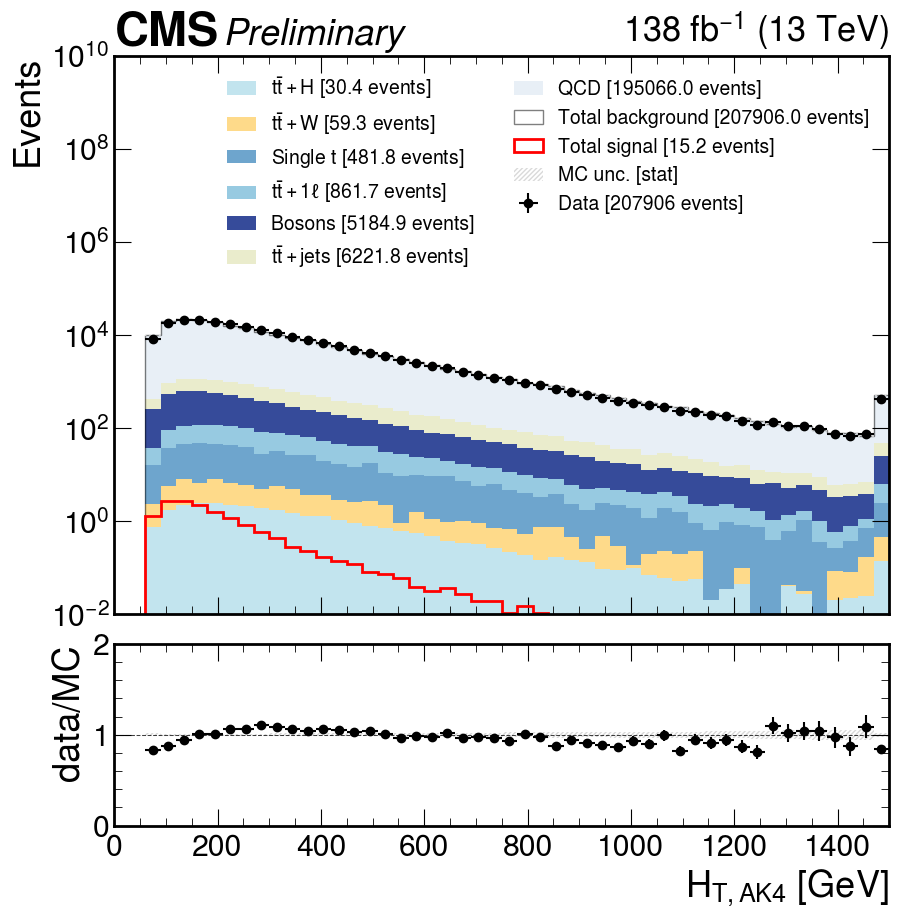

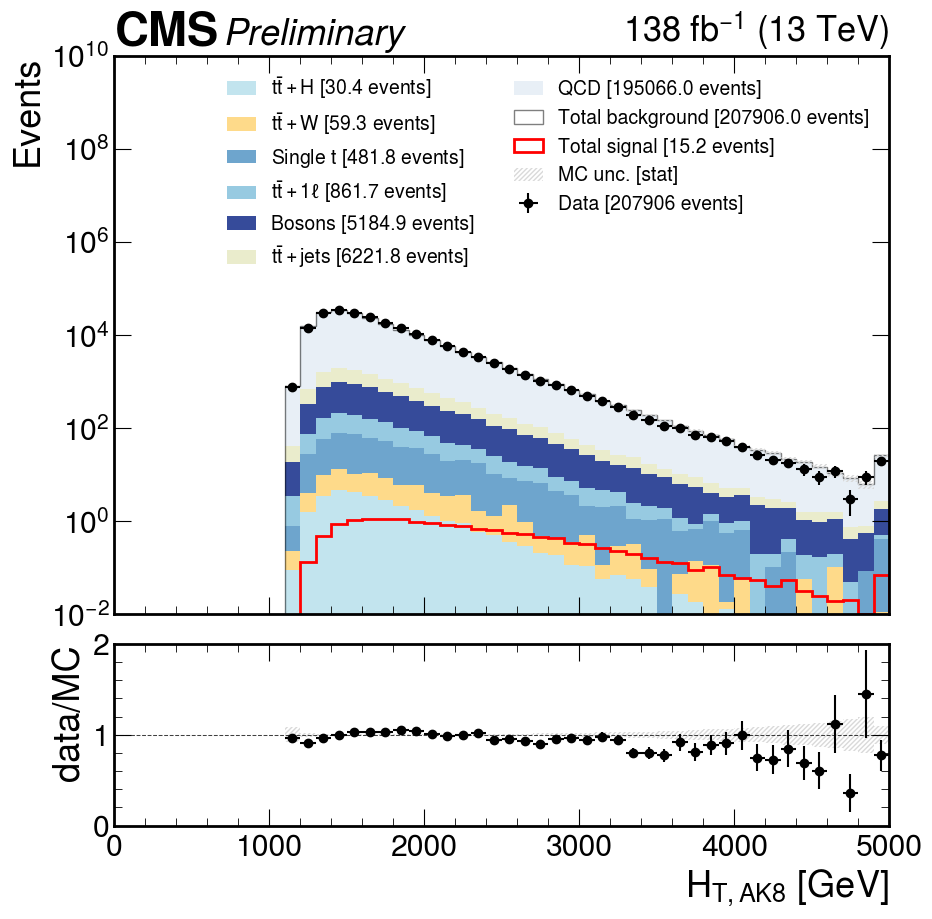

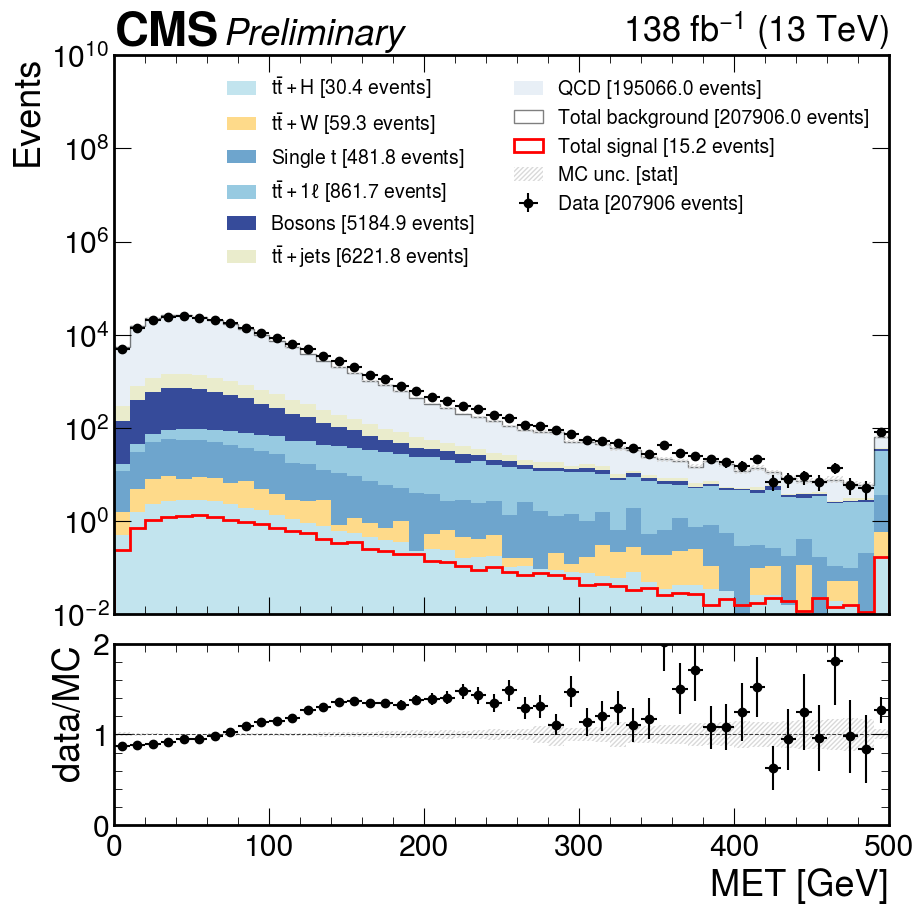

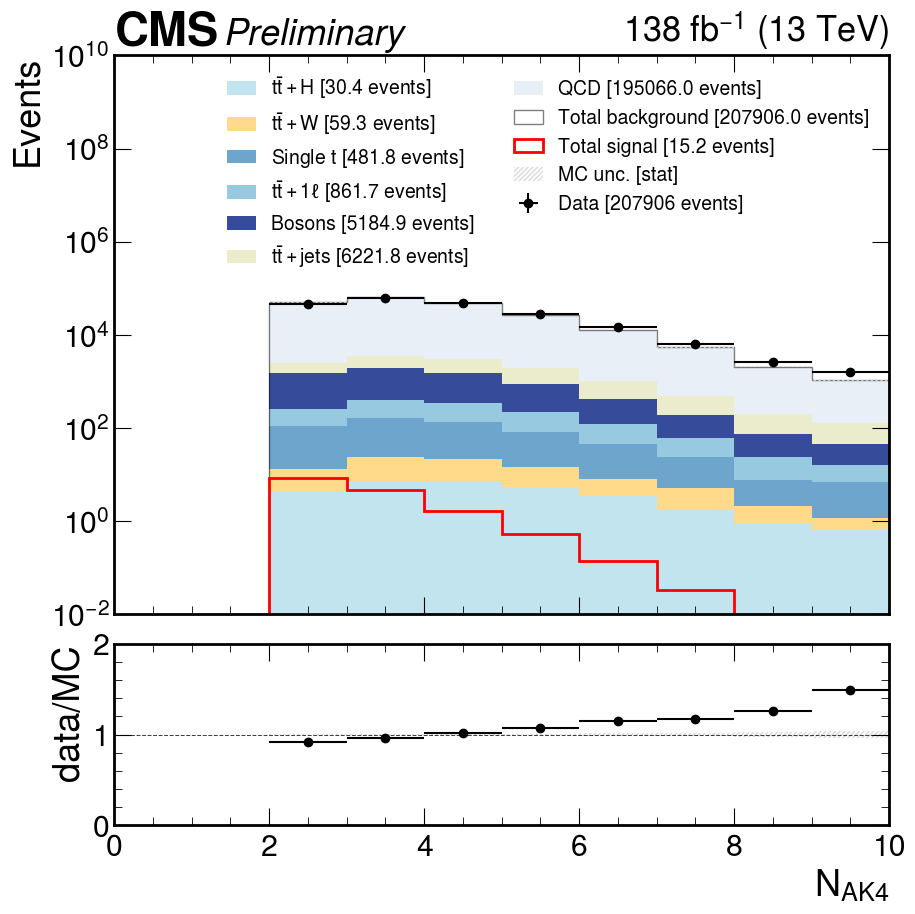

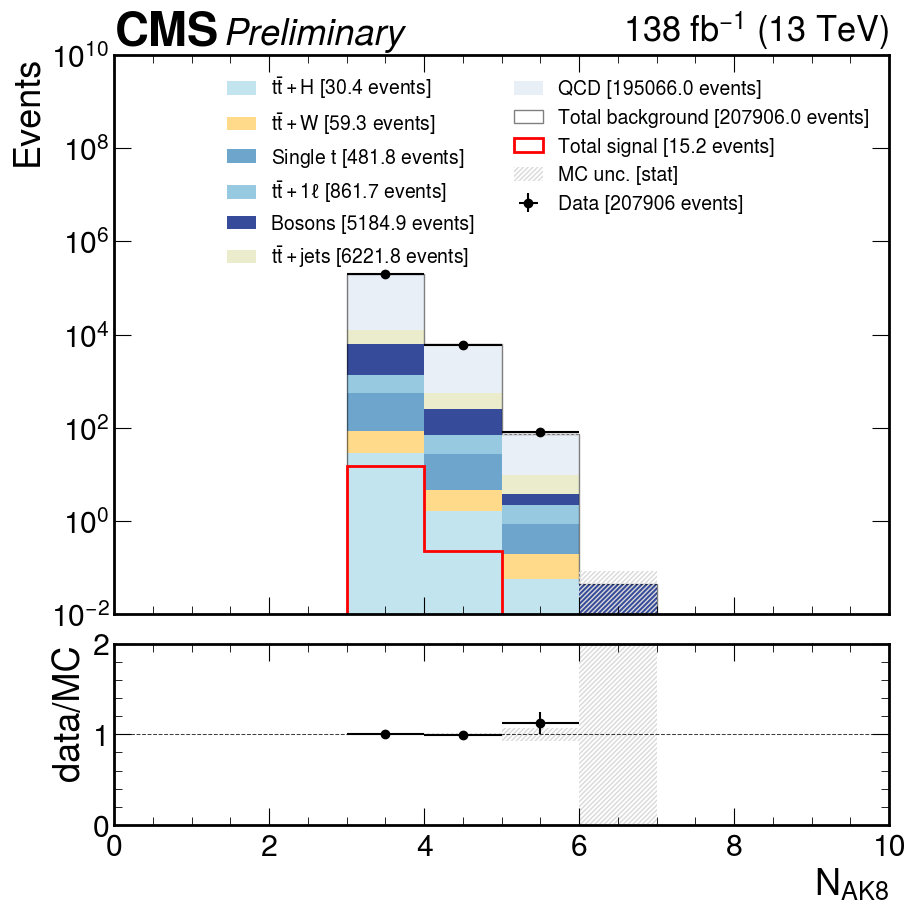

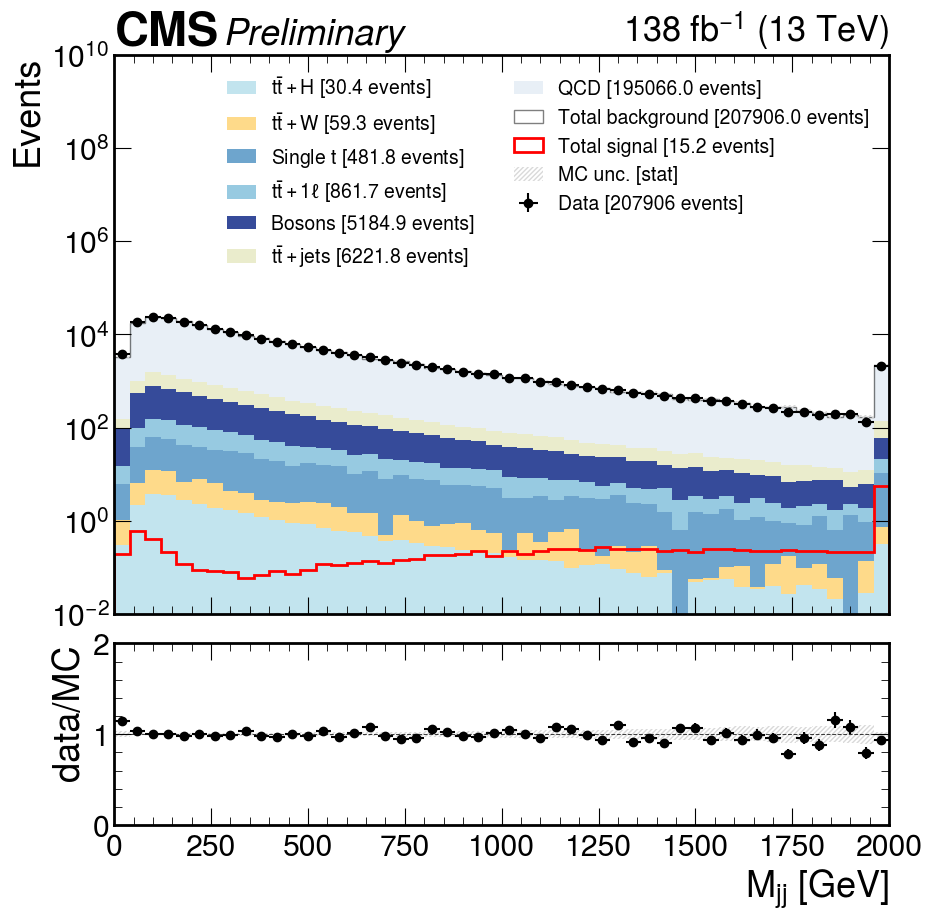

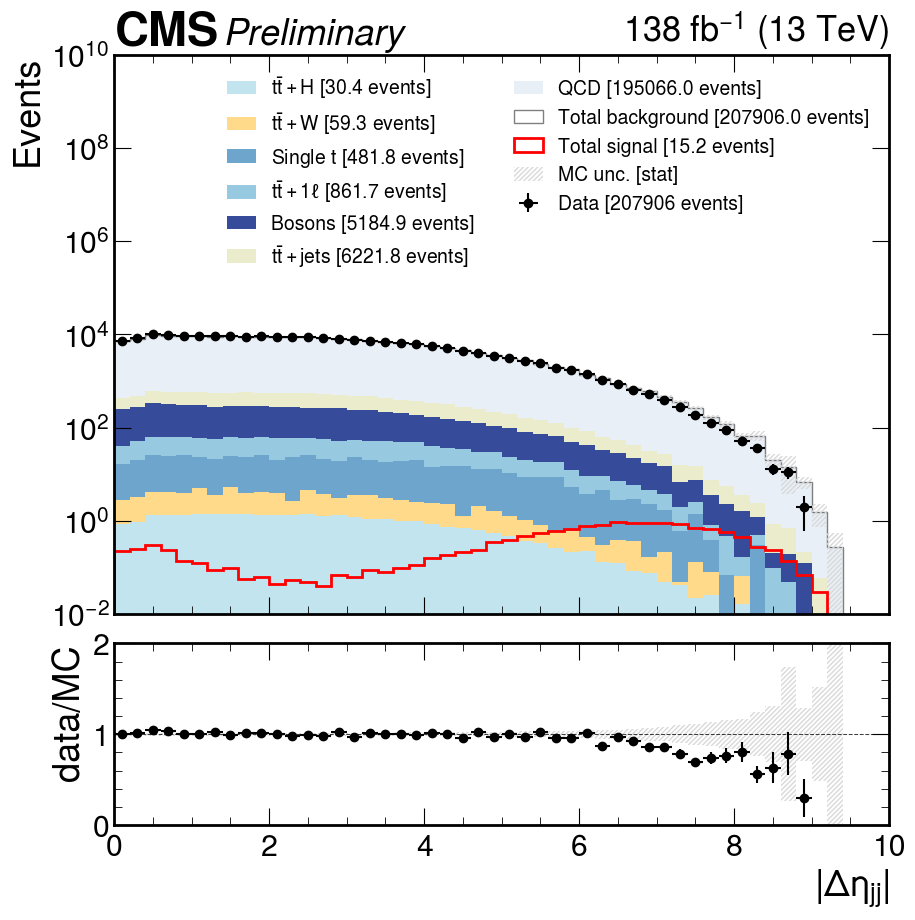

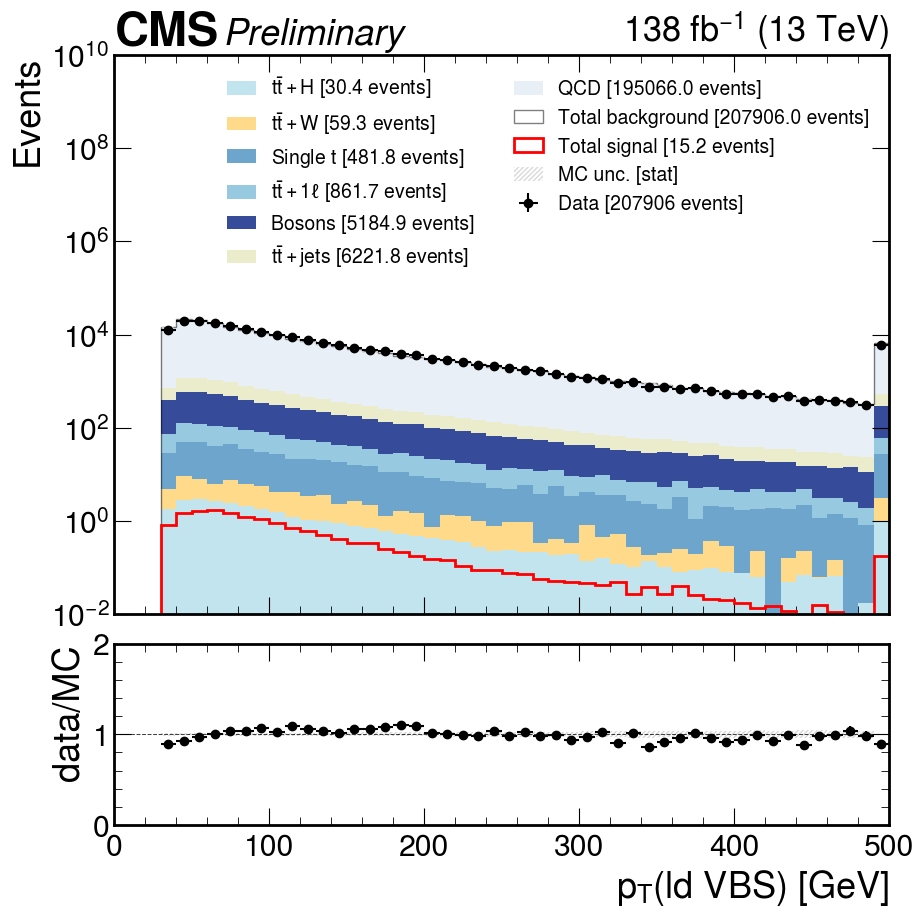

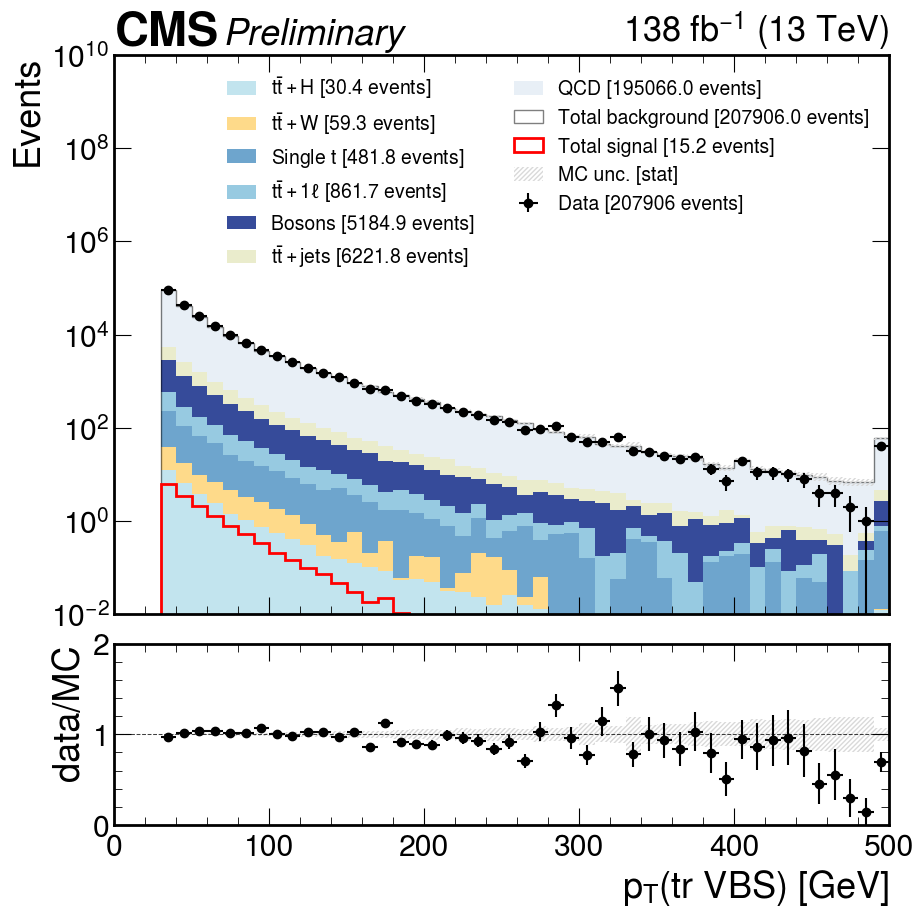

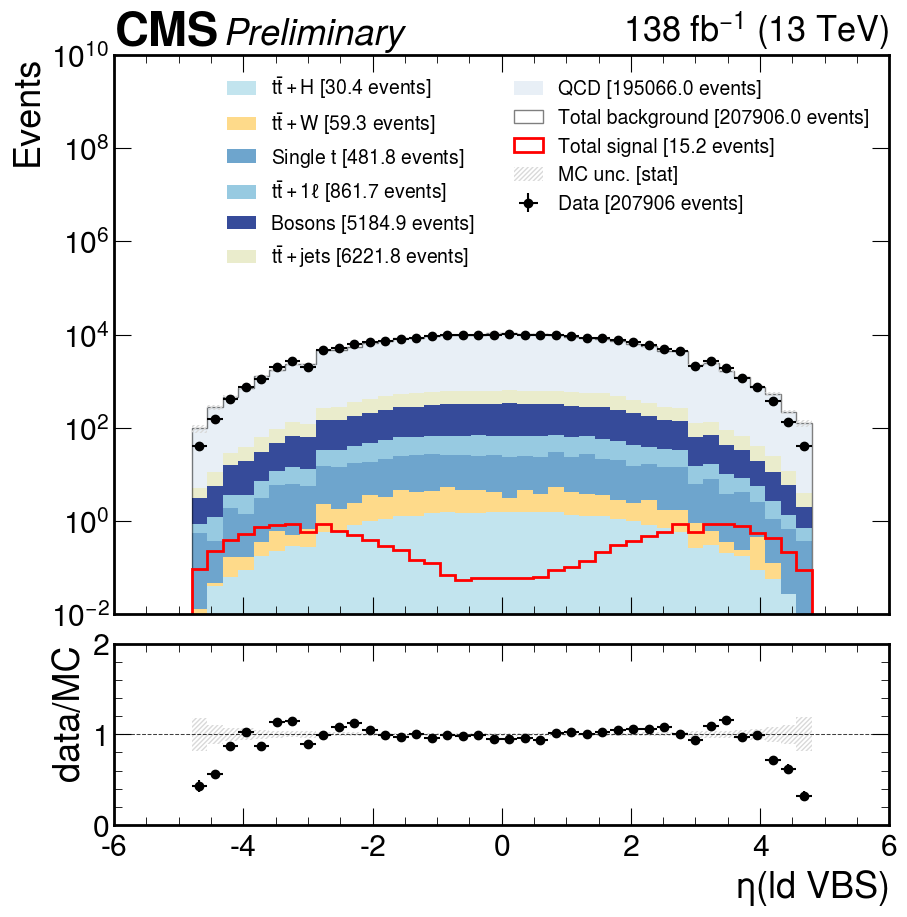

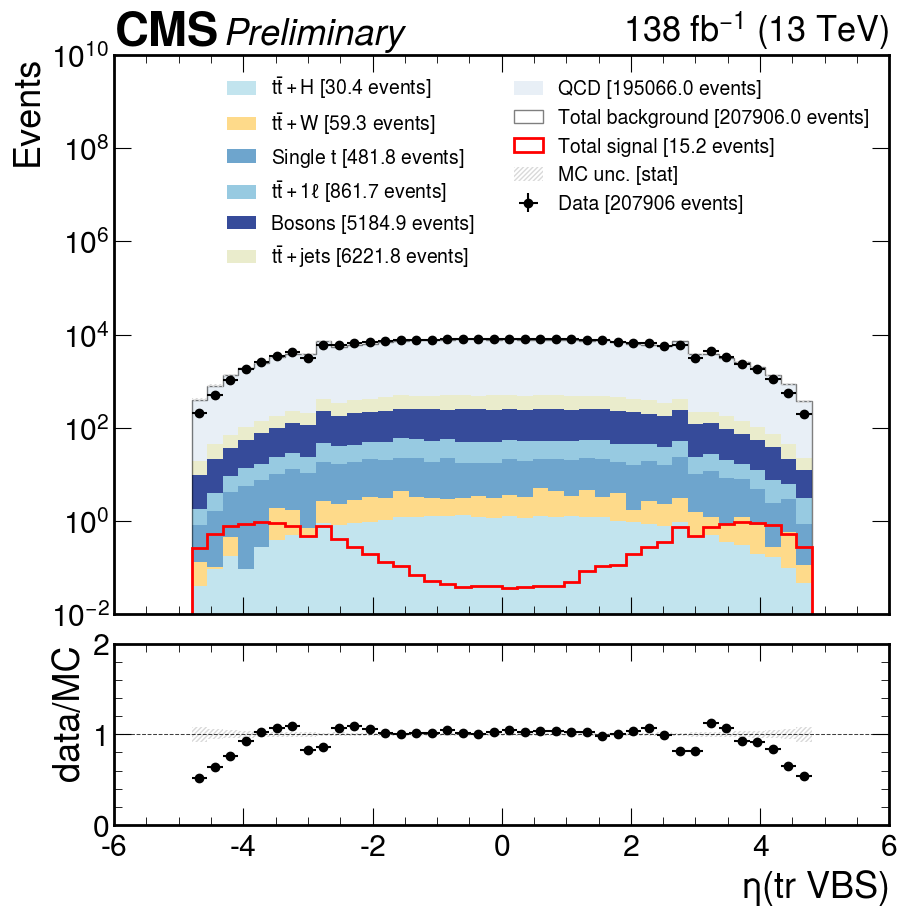

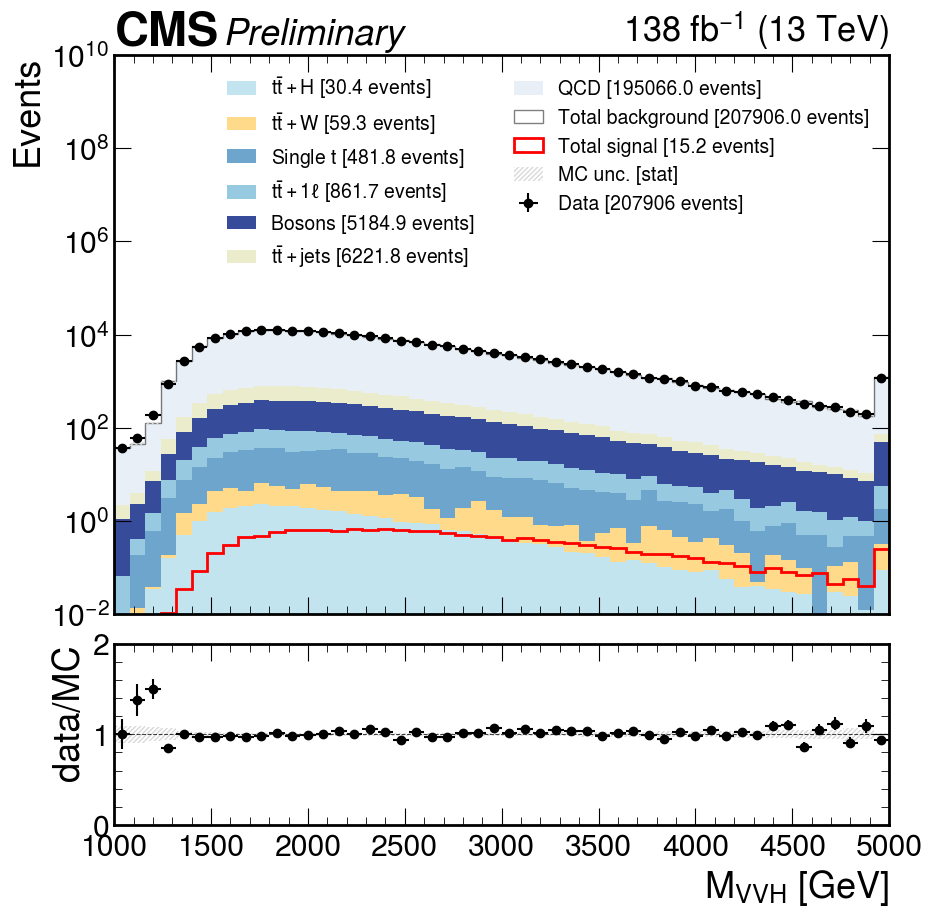

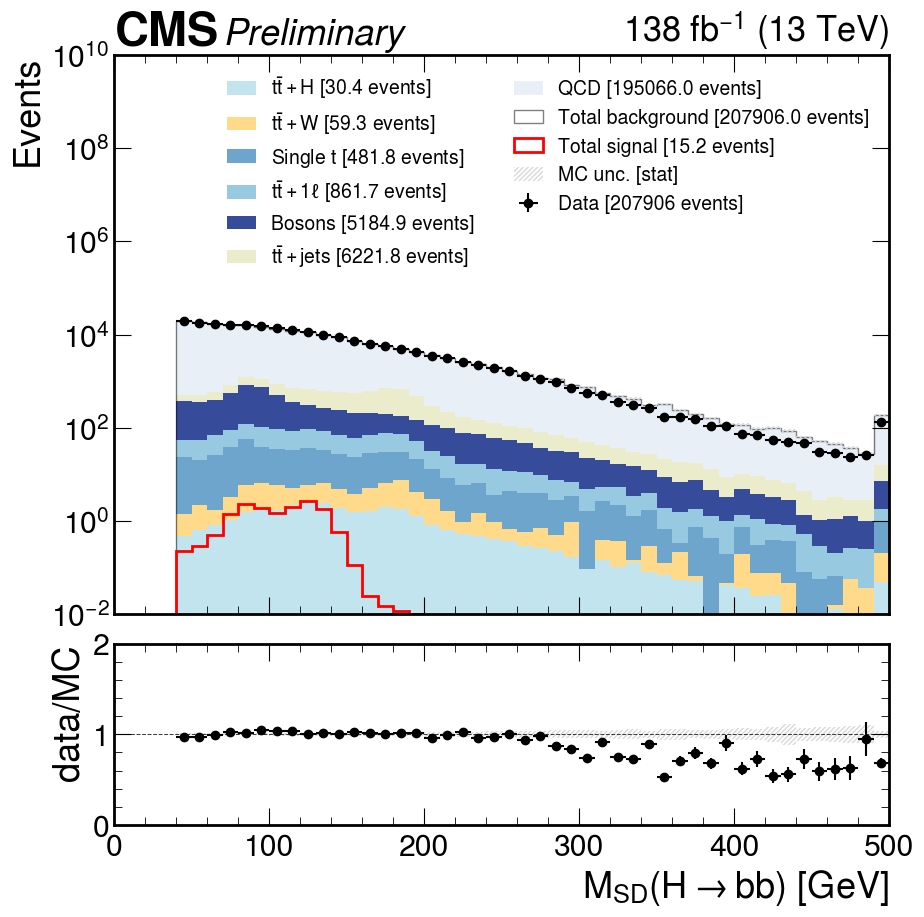

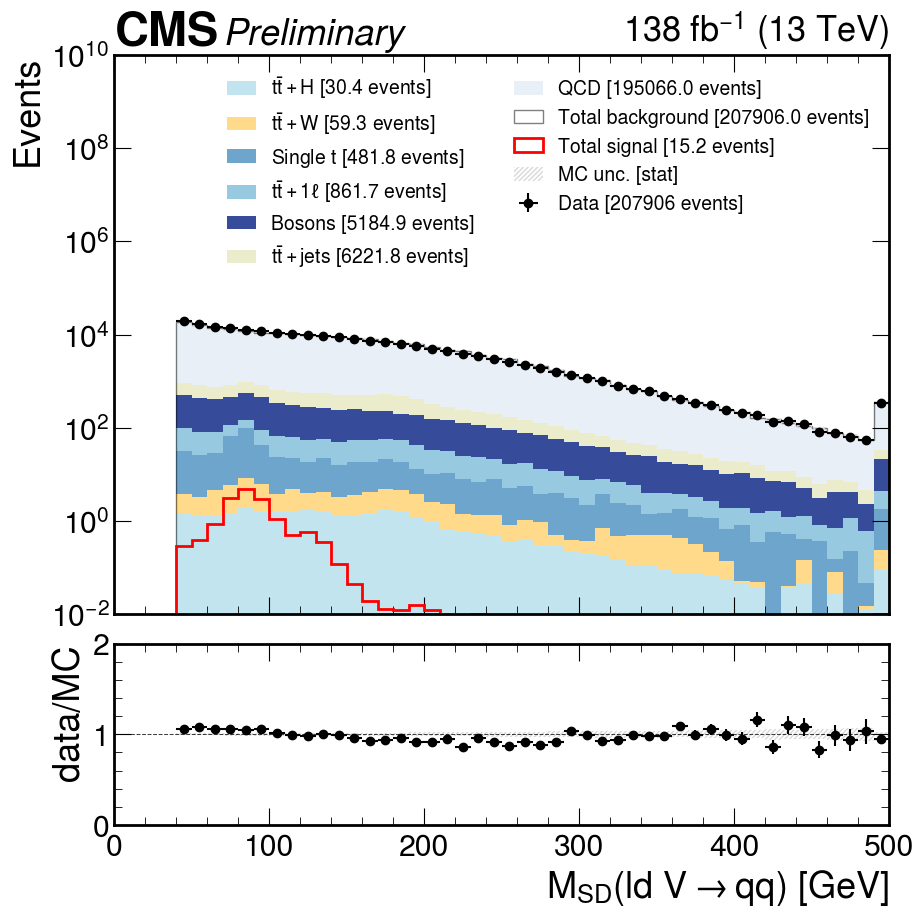

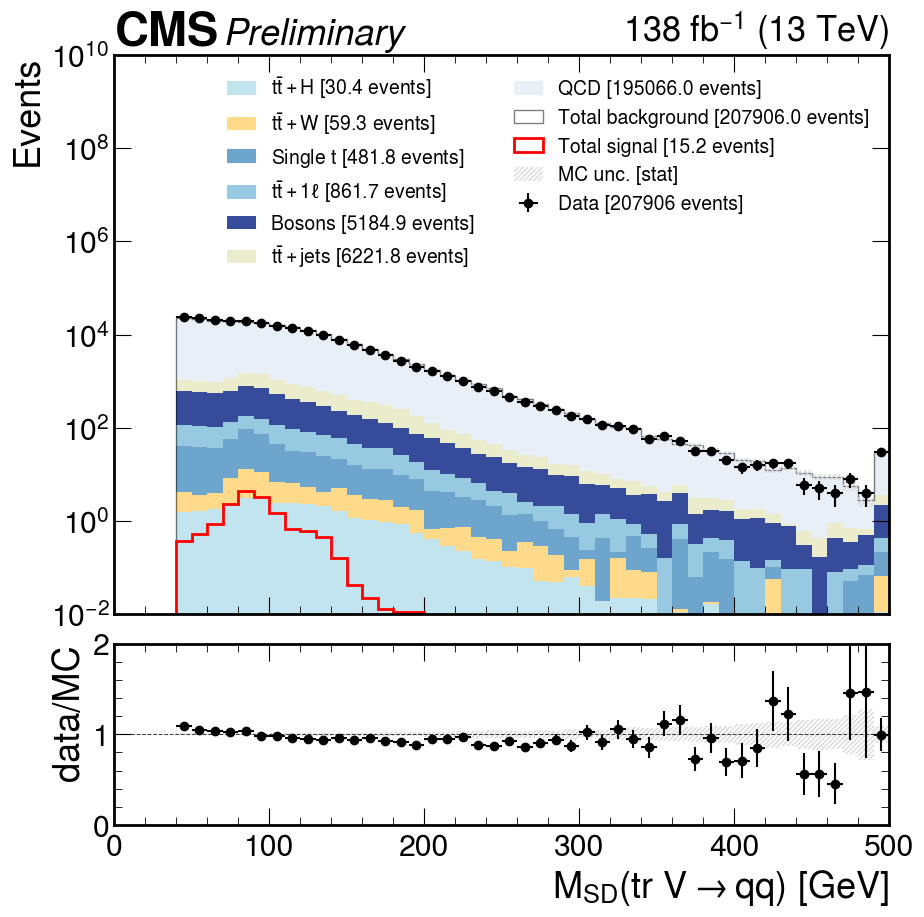

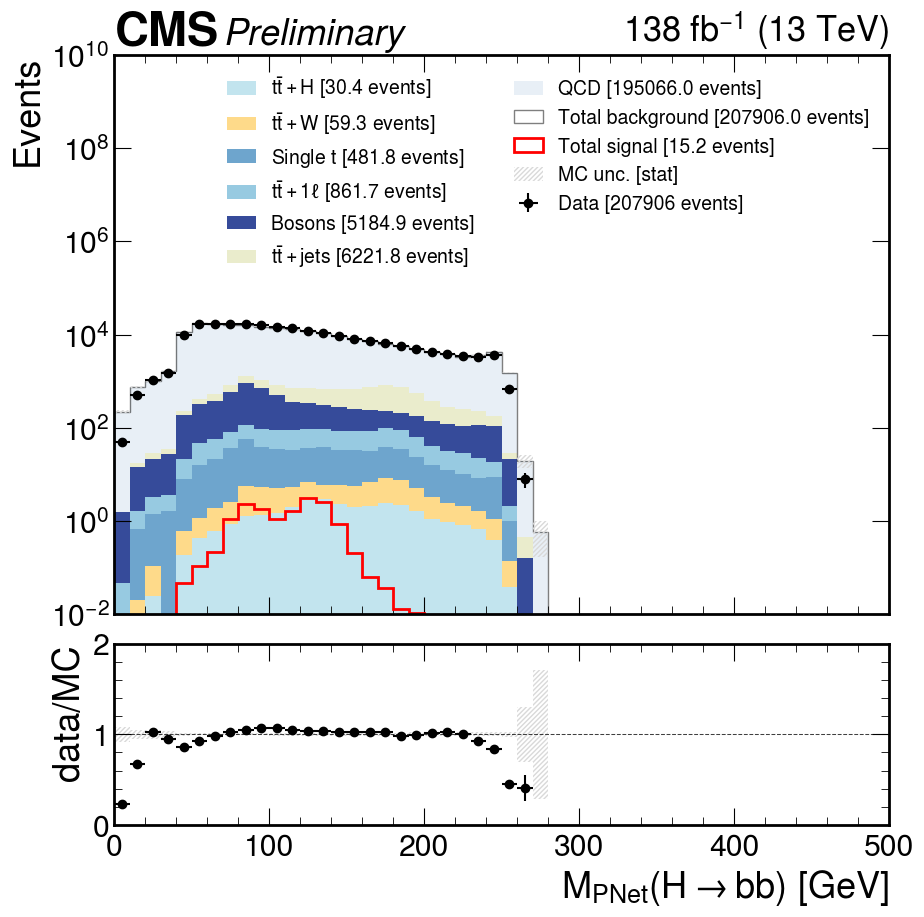

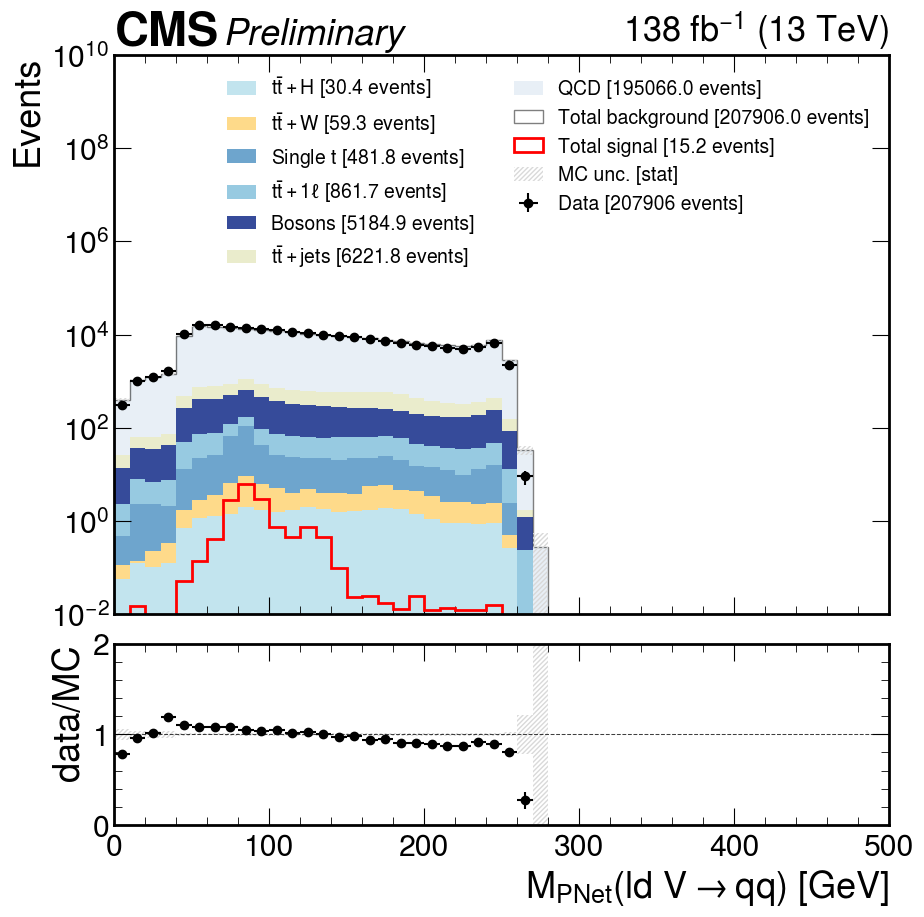

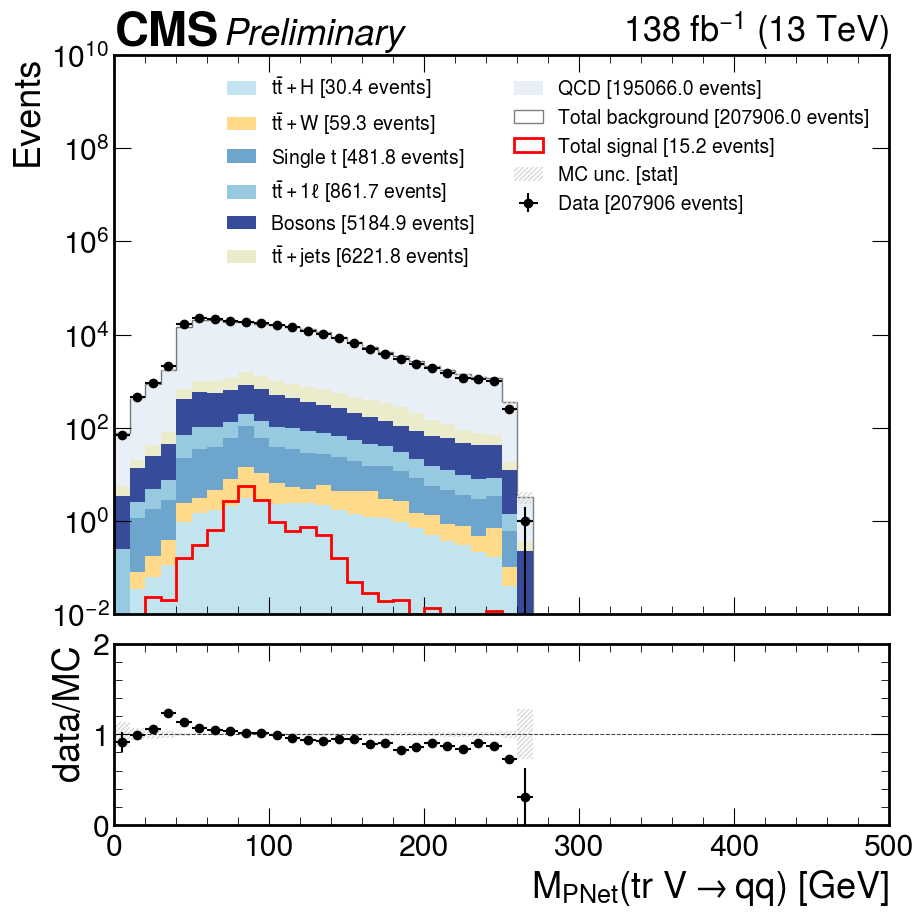

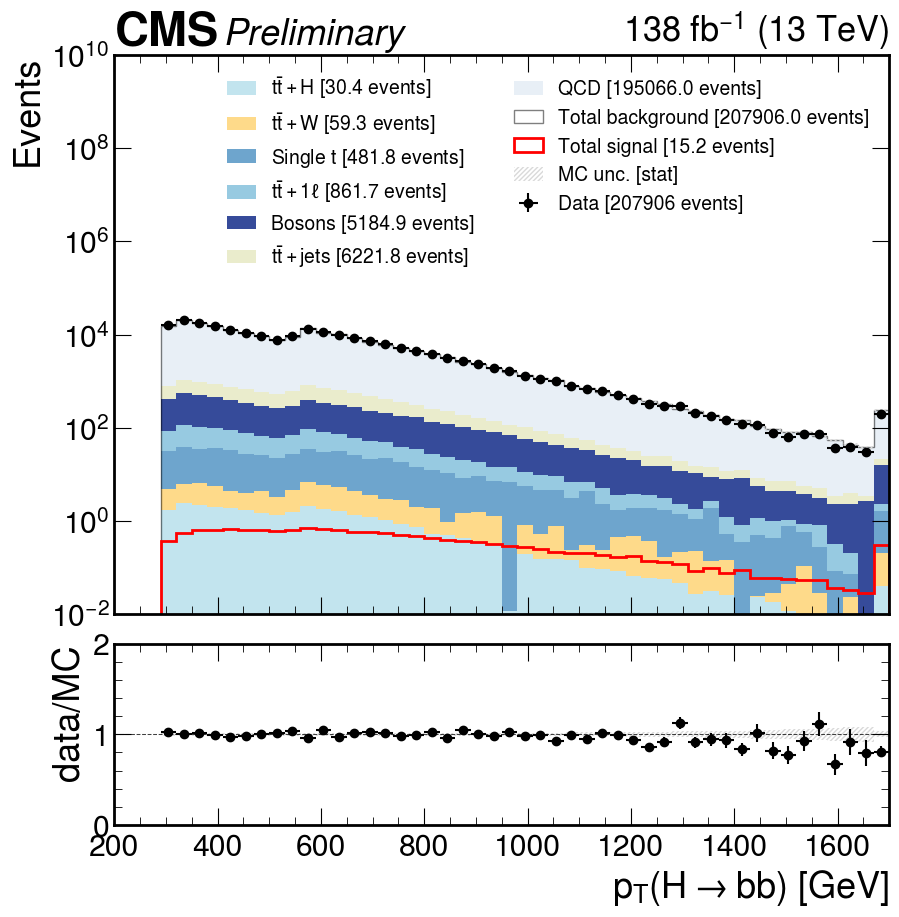

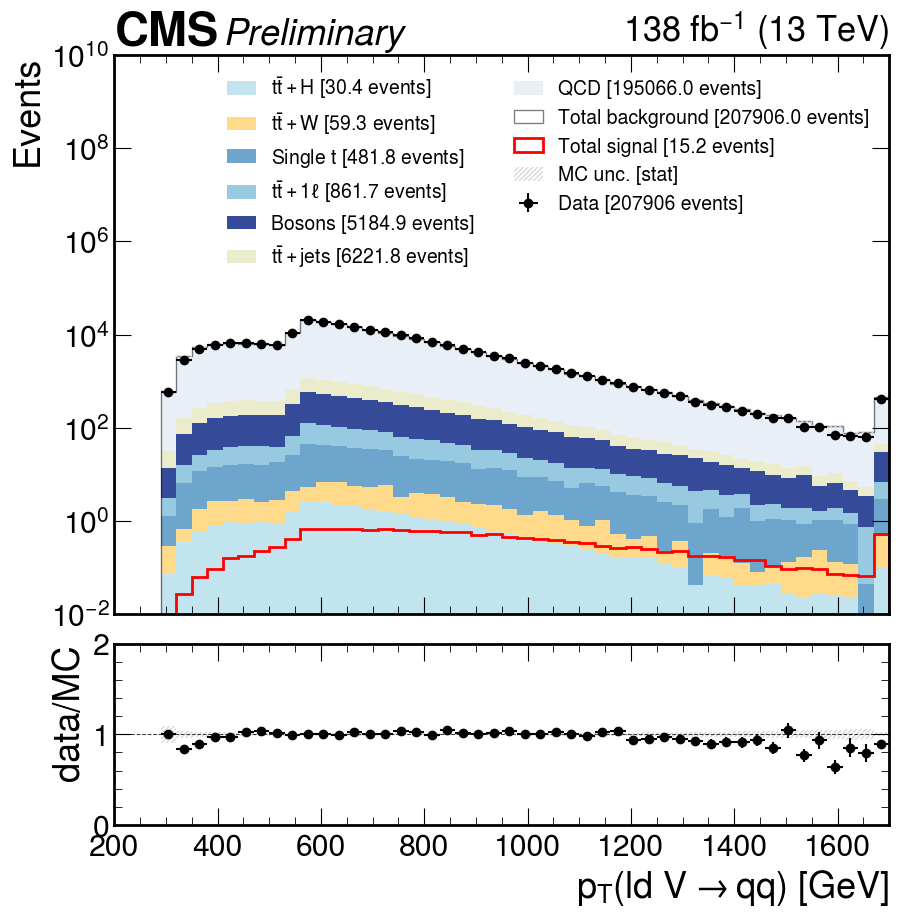

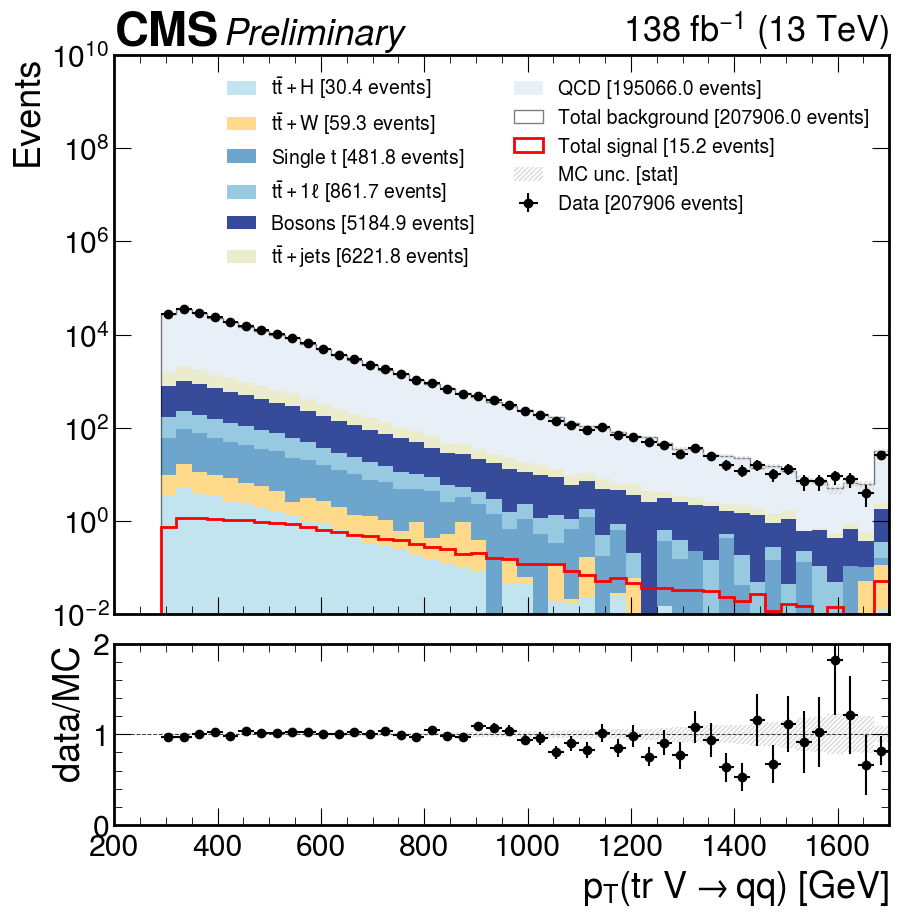

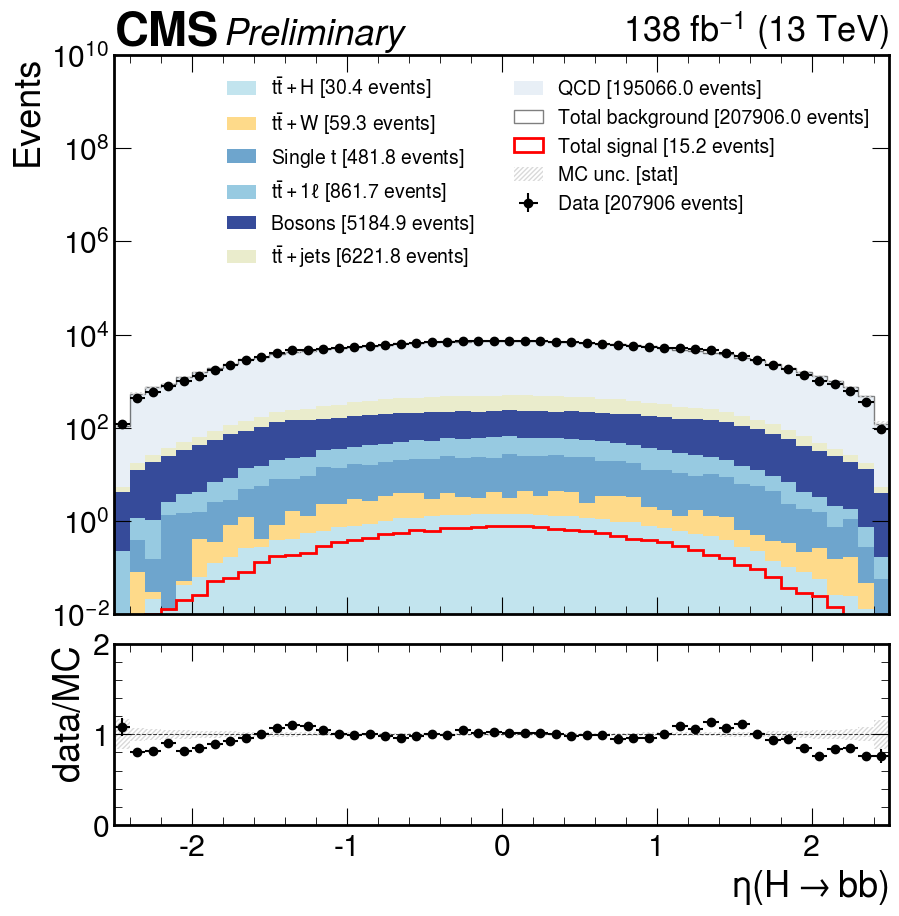

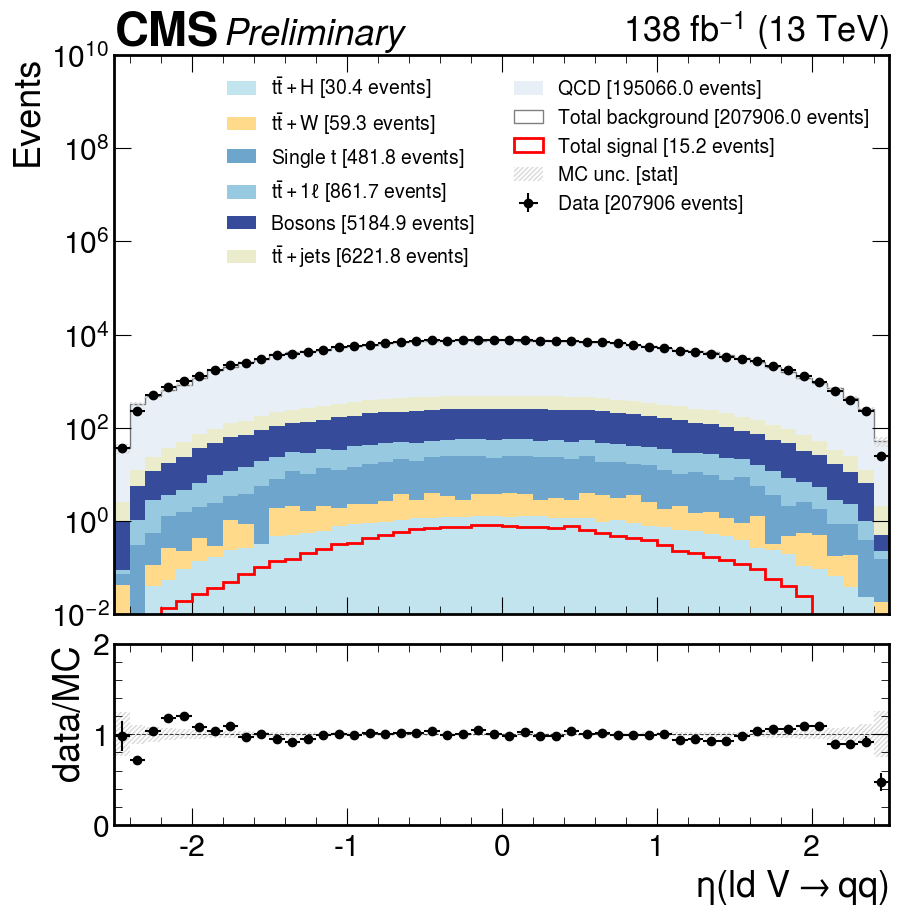

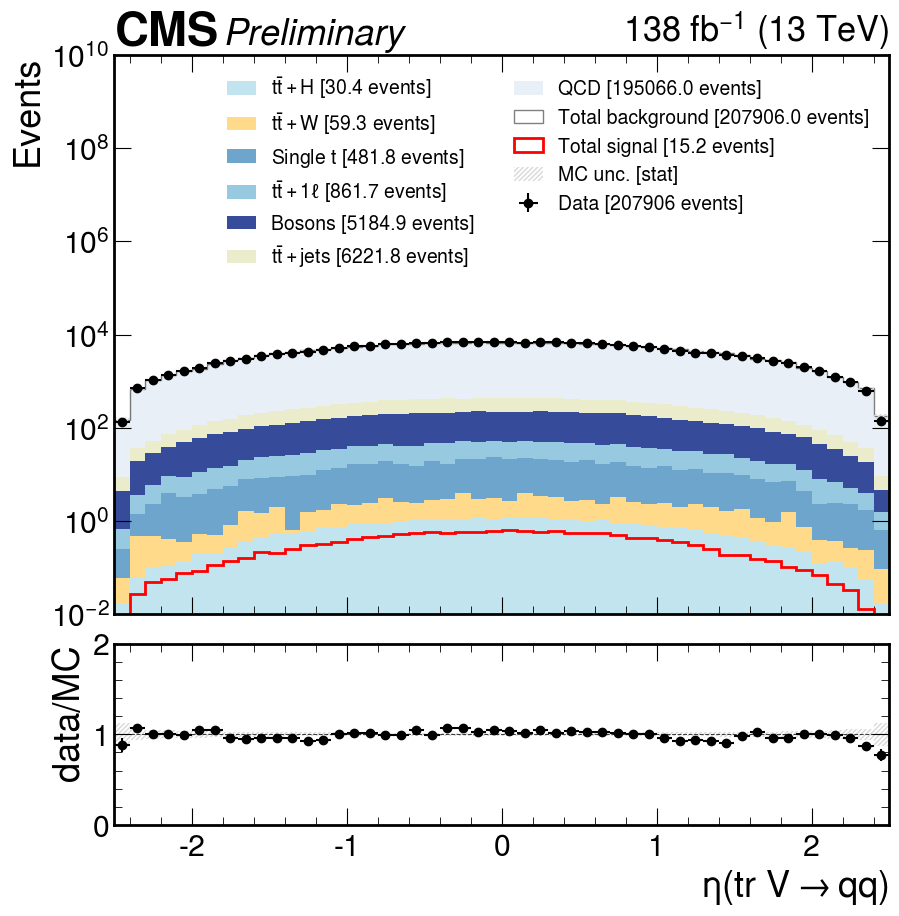

In [6]:
nbins = 50

plot_many(
    [
        # Event-level variables
        ("ST", np.linspace(0, 5000, nbins+1), r"$S_T$ [GeV]"),
        ("HT", np.linspace(0, 1500, nbins+1), r"$H_{T, AK4}$ [GeV]"),
        ("HT_fat", np.linspace(0, 5000, nbins+1), r"$H_{T, AK8}$ [GeV]"),
        ("MET", np.linspace(0, 500, nbins+1), "MET [GeV]"),
        ("n_jets", np.linspace(0, 10, 11), r"$N_{AK4}$"),
        ("n_fatjets", np.linspace(0, 10, 11), r"$N_{AK8}$"),
        # VBS variables
        ("M_jj", np.linspace(0, 2000, nbins+1), r"$M_{jj}$ [GeV]"),
        ("abs_deta_jj", np.linspace(0, 10, nbins+1), r"$|\Delta\eta_{jj}|$"),
        ("ld_vbsjet_pt", np.linspace(0, 500, nbins+1), r"$p_T($ld VBS$)$ [GeV]"),
        ("tr_vbsjet_pt", np.linspace(0, 500, nbins+1), r"$p_T($tr VBS$)$ [GeV]"),
        ("ld_vbsjet_eta", np.linspace(-6, 6, nbins+1), r"$\eta($ld VBS$)$"),
        ("tr_vbsjet_eta", np.linspace(-6, 6, nbins+1), r"$\eta($tr VBS$)$"),
        # VVH variables
        ("M_VVH", np.linspace(1000, 5000, nbins+1), r"$M_{VVH}$ [GeV]"),
        # Fat jet MSD
        ("hbbfatjet_msoftdrop", np.linspace(0, 500, nbins+1), r"$M_{SD}(H\rightarrow bb)$ [GeV]"),
        ("ld_vqqfatjet_msoftdrop", np.linspace(0, 500, nbins+1), r"$M_{SD}($ld $V\rightarrow qq)$ [GeV]"),
        ("tr_vqqfatjet_msoftdrop", np.linspace(0, 500, nbins+1), r"$M_{SD}($tr $V\rightarrow qq)$ [GeV]"),
        # Fat jet ParticleNet mass
        ("hbbfatjet_mass", np.linspace(0, 500, nbins+1), r"$M_{PNet}(H\rightarrow bb)$ [GeV]"),
        ("ld_vqqfatjet_mass", np.linspace(0, 500, nbins+1), r"$M_{PNet}($ld $V\rightarrow qq)$ [GeV]"),
        ("tr_vqqfatjet_mass", np.linspace(0, 500, nbins+1), r"$M_{PNet}($tr $V\rightarrow qq)$ [GeV]"),
        # Fat jet pt
        ("hbbfatjet_pt", np.linspace(200, 1700, nbins+1), r"$p_T(H\rightarrow bb)$ [GeV]"),
        ("ld_vqqfatjet_pt", np.linspace(200, 1700, nbins+1), r"$p_T($ld $V\rightarrow qq)$ [GeV]"),
        ("tr_vqqfatjet_pt", np.linspace(200, 1700, nbins+1), r"$p_T($tr $V\rightarrow qq)$ [GeV]"),
        # Fat jet eta
        ("hbbfatjet_eta", np.linspace(-2.5, 2.5, nbins+1), r"$\eta(H\rightarrow bb)$"),
        ("ld_vqqfatjet_eta", np.linspace(-2.5, 2.5, nbins+1), r"$\eta($ld $V\rightarrow qq)$"),
        ("tr_vqqfatjet_eta", np.linspace(-2.5, 2.5, nbins+1), r"$\eta($tr $V\rightarrow qq)$"),
    ],
    sel="objsel",
    norm=False,
    sig_scale=1,
    logy=True,
    hist_ylim=[1e-2, 1e10]
)

# After QCD resampling

In [7]:
babies = sorted(glob.glob(f"../analysis/studies/vbsvvhjets/output_{TAG}/Run2/*.root"))
sig_babies = [baby for baby in babies if "VBSVVH" in baby]
bkg_babies = [baby for baby in babies if "VBS" not in baby and "data" not in baby]
data_babies = [baby for baby in babies if "data" in baby]
print("Signal:")
print("\n".join(sig_babies))
print("Background:")
print("\n".join(bkg_babies))
print("Data:")
print("\n".join(data_babies))

Signal:
../analysis/studies/vbsvvhjets/output_abcdnet_v3/Run2/inferences/VBSVVH.root
Background:
../analysis/studies/vbsvvhjets/output_abcdnet_v3/Run2/inferences/Bosons.root
../analysis/studies/vbsvvhjets/output_abcdnet_v3/Run2/inferences/QCD.root
../analysis/studies/vbsvvhjets/output_abcdnet_v3/Run2/inferences/SingleTop.root
../analysis/studies/vbsvvhjets/output_abcdnet_v3/Run2/inferences/TT1L.root
../analysis/studies/vbsvvhjets/output_abcdnet_v3/Run2/inferences/TTH.root
../analysis/studies/vbsvvhjets/output_abcdnet_v3/Run2/inferences/TTHad.root
../analysis/studies/vbsvvhjets/output_abcdnet_v3/Run2/inferences/TTW.root
Data:
../analysis/studies/vbsvvhjets/output_abcdnet_v3/Run2/inferences/data.root


In [8]:
vbsvvh = Validation(
    sig_root_files=sig_babies,
    bkg_root_files=bkg_babies,
    data_root_files=data_babies,
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", 
        "pu_sf", 
        "prefire_sf", 
        "xwqq_ld_vqq_sf", 
        "xwqq_tr_vqq_sf",
        "xbb_sf"
    ],
    plots_dir=PLOTSDIR,
    sample_labels = {
        "VBSVVH": r"VBS VVH $(C_{2V} = 2)$", 
        "TTHad": r"$t\bar{t}+$jets",
        "TT1L": r"$t\bar{t}+1\ell$",
        "QCD": "QCD",
        "SingleTop": r"Single $t$",
        "TTH": r"$t\bar{t}+H$",
        "TTW": r"$t\bar{t}+W$",
    },
)

vbsvvh.df["objsel"] = True
vbsvvh.df["presel"] = vbsvvh.df.eval(
    "objsel and hbbfatjet_xbb > 0.5 and ld_vqqfatjet_xwqq > 0.3 and tr_vqqfatjet_xwqq > 0.3"
)

vbsvvh.make_selection("presel")

bkg_count = vbsvvh.bkg_count()
qcd_count = vbsvvh.sample_count("QCD")
data_count = vbsvvh.data_count()

vbsvvh.df.loc[(vbsvvh.df.name == "QCD") & vbsvvh.df.presel, "event_weight"] *= (data_count - (bkg_count - qcd_count))/(qcd_count)

Loading data babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


In [9]:
# New cuts: "bdt > 0.75 and hbbfatjet_score > 0.9 and ld_vqqfatjet_score > 0.80 and tr_vqqfatjet_score > 0.65"

vbsvvh.df["dphi_VV"] = np.arccos(np.cos(vbsvvh.df.ld_vqqfatjet_phi - vbsvvh.df.tr_vqqfatjet_phi))
vbsvvh.df["dphi_ldVH"] = np.arccos(np.cos(vbsvvh.df.hbbfatjet_phi - vbsvvh.df.ld_vqqfatjet_phi))
vbsvvh.df["dphi_trVH"] = np.arccos(np.cos(vbsvvh.df.hbbfatjet_phi - vbsvvh.df.tr_vqqfatjet_phi))
vbsvvh.df["dphi_jj"] = np.arccos(np.cos(vbsvvh.df.ld_vbsjet_phi - vbsvvh.df.tr_vbsjet_phi))

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/abs_deta_jj_data_vs_mc_(regionA_or_regionB).pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/abs_deta_jj_data_vs_mc_log_(regionC_or_regionD).pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/abs_deta_jj_data_vs_mc_(regionA_or_regionB).pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/abs_deta_jj_data_vs_mc_log_(regionC_or_regionD).pdf


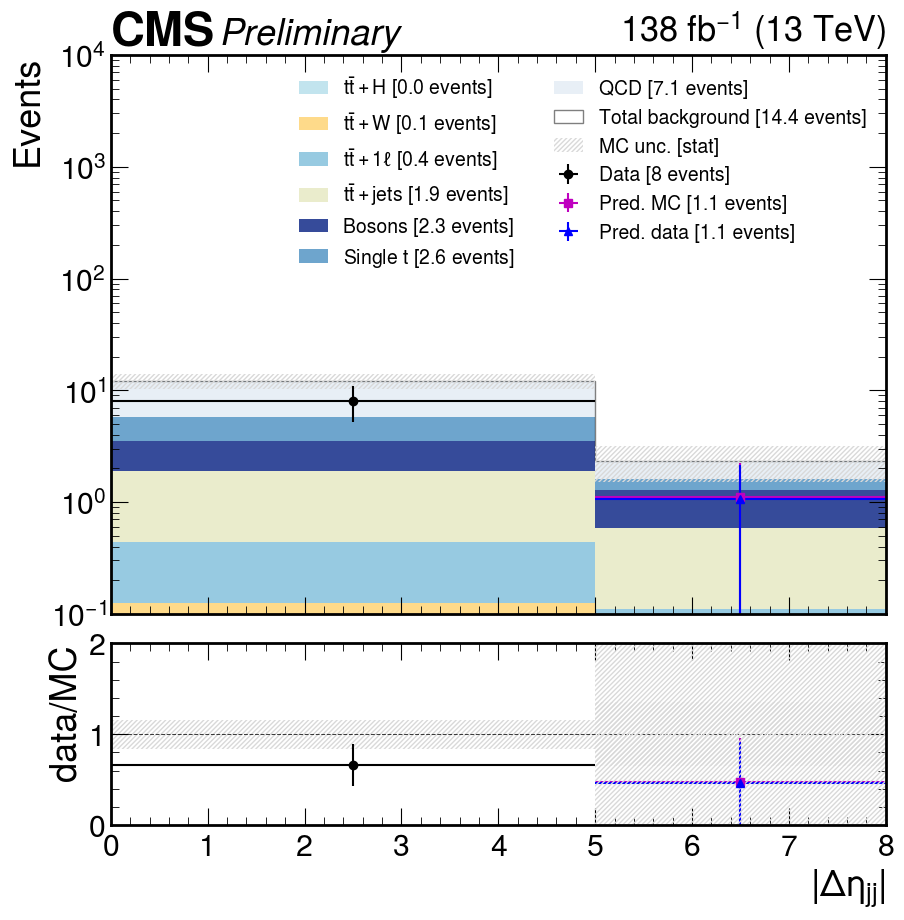

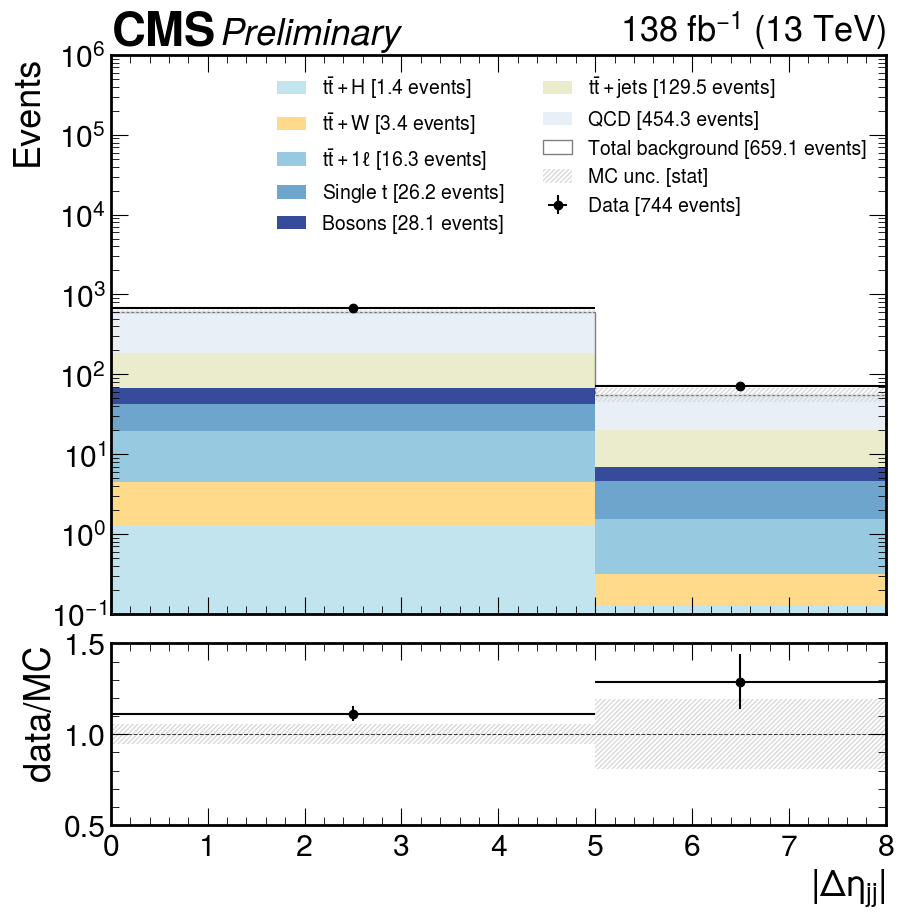

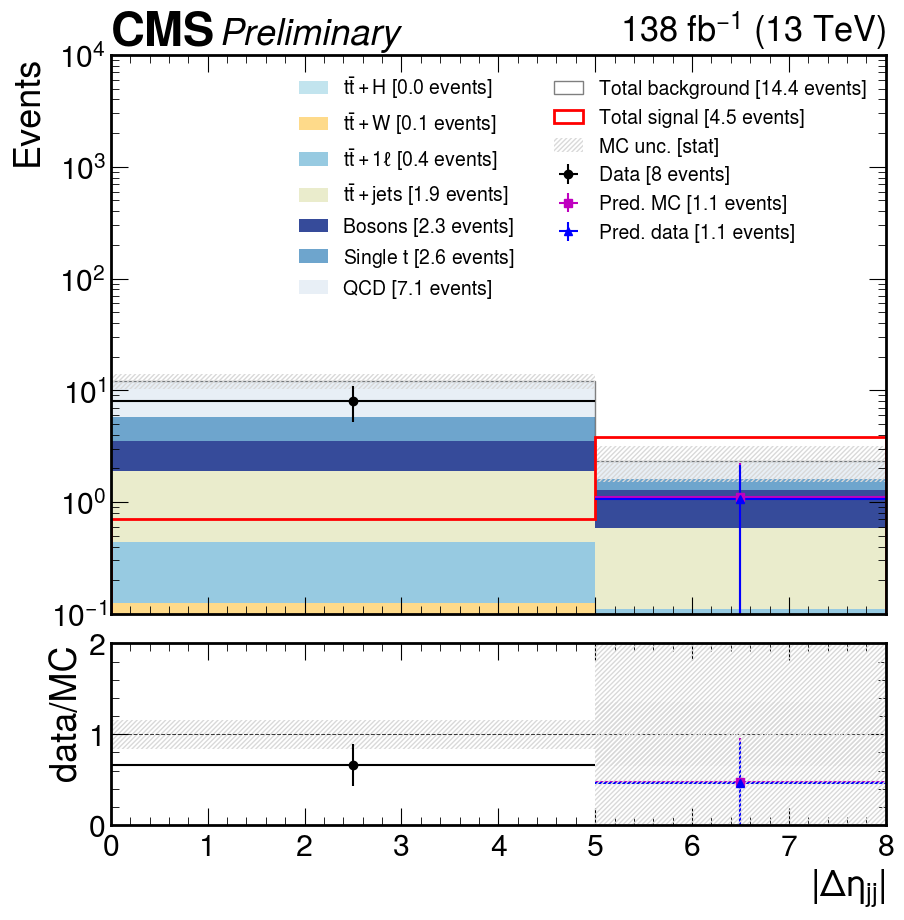

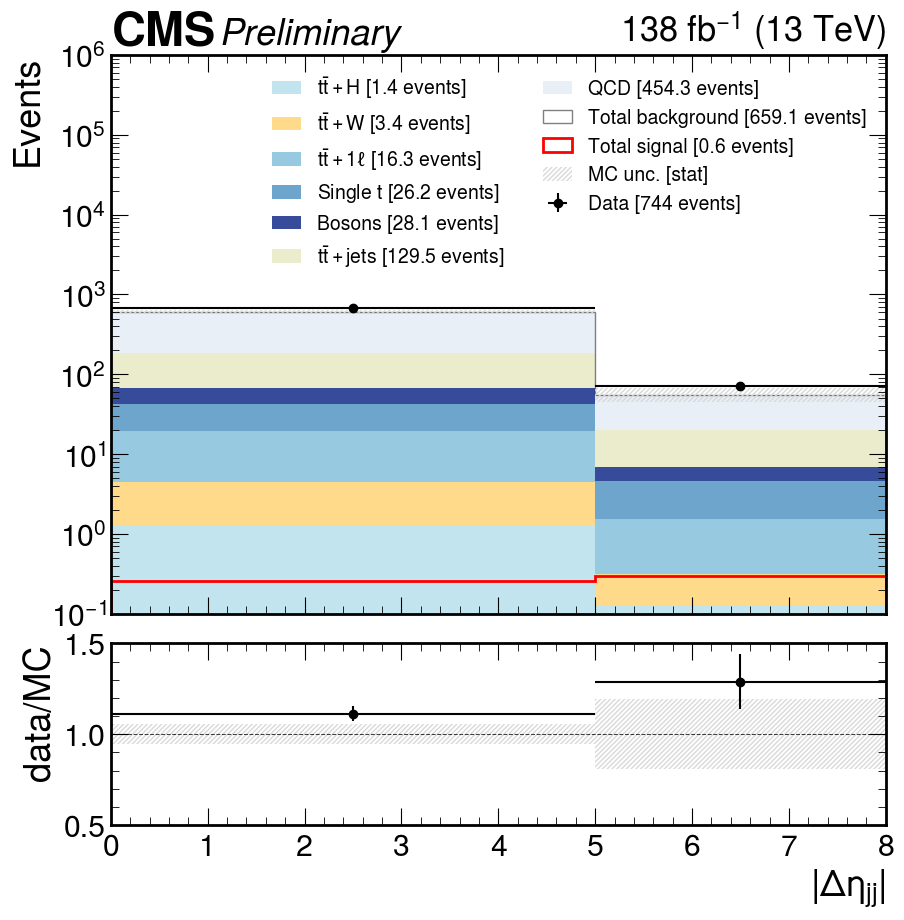

In [10]:
column = "abs_deta_jj"
bins = [0, 5, 8]
x_label = r"$|\Delta\eta_{jj}|$"

for sig_scale in [0, 1]:

    SR_like = "presel and (hbbfatjet_xbb > 0.8 and ld_vqqfatjet_xwqq > 0.8 and tr_vqqfatjet_xwqq > 0.7)"
    VBS_cut = "(abs_deta_jj > 5)"
    BDT_cut = "(abcdnet_score > 0.89)"

    vbsvvh.df["regionC"] = vbsvvh.df.eval(f"({SR_like} and {VBS_cut} and not {BDT_cut})")
    vbsvvh.df["regionD"] = vbsvvh.df.eval(f"({SR_like} and not {VBS_cut} and not {BDT_cut})")
    vbsvvh.df["regionB"] = vbsvvh.df.eval(f"({SR_like} and not {VBS_cut} and {BDT_cut})")
    vbsvvh.df["regionA"] = vbsvvh.df.eval(f"({SR_like} and {VBS_cut} and {BDT_cut})")

    DtoC = vbsvvh.data_count(selection="regionC")/vbsvvh.data_count(selection="regionD")
    DtoC_mc = vbsvvh.bkg_count(selection="regionC")/vbsvvh.bkg_count(selection="regionD")


    hist_axes, ratio_axes = vbsvvh.plot_data_vs_mc(
        column, 
        bins=bins, 
        selection=f"(regionA or regionB)",
        x_label=x_label,
        stacked=True,
        blinded_range=(4, 8),
        blinded_box=False,
        autoblind=False,
        sig_scale=sig_scale
    )

    # Get numerator (data) and denominator (bkg MC)
    denom_df = vbsvvh.bkg_df(selection="regionA")
    denom = yahist.Hist1D(
        [5],
        bins=bins,
        weights=denom_df.event_weight.sum(),
    );
    numer_df = vbsvvh.data_df(selection="regionB") # numer = numerator of ratio plot, not extrapolation
    numer = yahist.Hist1D(
        [5],
        bins=bins,
        weights=numer_df.event_weight.sum()*DtoC,
        label=f"Pred. data [{len(numer_df)*DtoC:.1f} events]",
        color="b"
    );
    numer_mc_df = vbsvvh.bkg_df(selection="regionB") # numer = numerator of ratio plot, not extrapolation
    numer_mc = yahist.Hist1D(
        [5],
        bins=bins,
        weights=numer_mc_df.event_weight.sum()*DtoC_mc,
        label=f"Pred. MC [{np.sum(numer_mc_df.event_weight)*DtoC_mc:.1f} events]",
        color="m"
    );

    # Get ratio
    ratio = numer/denom
    # Set ratio errors to data relative stat error times the ratio
    numer_counts = numer.counts
    numer_counts[numer_counts == 0] = 1e-12
    ratio._errors = (numer.errors/numer_counts)*ratio.counts

    # Get ratio
    ratio_mc = numer_mc/denom
    # Set ratio errors to data relative stat error times the ratio
    numer_mc_counts = numer_mc.counts
    numer_mc_counts[numer_mc_counts == 0] = 1e-12
    ratio_mc._errors = (numer_mc.errors/numer_mc_counts)*ratio_mc.counts

    # Plot hists and ratio
    numer_mc.plot(ax=hist_axes, errors=True, fmt="s")
    ratio_mc.plot(ax=ratio_axes, errors=True, fmt="s")
    numer.plot(ax=hist_axes, errors=True, fmt="^")
    ratio.plot(ax=ratio_axes, errors=True, fmt="^")

    # Plot MC relative stat error on unity; this makes no sense, but is LHC common practice
    denom_counts = denom.counts
    denom_counts[denom_counts == 0] = 1e-12
    err_points = np.repeat(denom.edges, 2)[1:-1]
    err_high = np.repeat(1 + denom.errors/denom_counts, 2)
    err_low = np.repeat(1 - denom.errors/denom_counts, 2)
    ratio_axes.fill_between(
        err_points, err_high, err_low,
        step="mid",
        hatch="///////",
        facecolor="none",
        edgecolor=(0.85, 0.85, 0.85),
        linewidth=0.0,
        linestyle="-",
        zorder=2
    )

    hist_axes.legend(fontsize=14, ncol=2)

    ratio_axes.set_ylim([0., 2.0])
    ratio_axes.legend().remove()

    hist_axes.set_yscale("log")
    hist_axes.autoscale()
    hist_axes.set_ylim(bottom=1e-1, top=1e4)
    hist_axes.margins(x=0)
    if sig_scale == 0:
        plt.savefig(f"{PLOTSDIR}/regionsAB_closure.pdf")
    else:
        plt.savefig(f"{PLOTSDIR}/regionsAB_closure_signal.pdf")


    # bins = np.linspace(0, 8, 9)
    hist_axes, ratio_axes = vbsvvh.plot_data_vs_mc(
        column, 
        bins=bins, 
        selection="(regionC or regionD)",
        x_label=x_label,
        stacked=True,
        autoblind=False,
        logy=True,
        sig_scale=sig_scale
    )
    ratio_axes.set_ylim([0.5, 1.5]);
    hist_axes.set_ylim(bottom=1e-1, top=1e6);
    hist_axes.legend(fontsize=14, ncol=2);
    if sig_scale == 0:
        plt.savefig(f"{PLOTSDIR}/regionsCD_closure.pdf")
    else:
        plt.savefig(f"{PLOTSDIR}/regionsCD_closure_signal.pdf")

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/abcdnet_score_data_vs_mc_(regionA_or_regionC).pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/abcdnet_score_data_vs_mc_log_(regionB_or_regionD).pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/abcdnet_score_data_vs_mc_(regionA_or_regionC).pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/abcdnet_score_data_vs_mc_log_(regionB_or_regionD).pdf


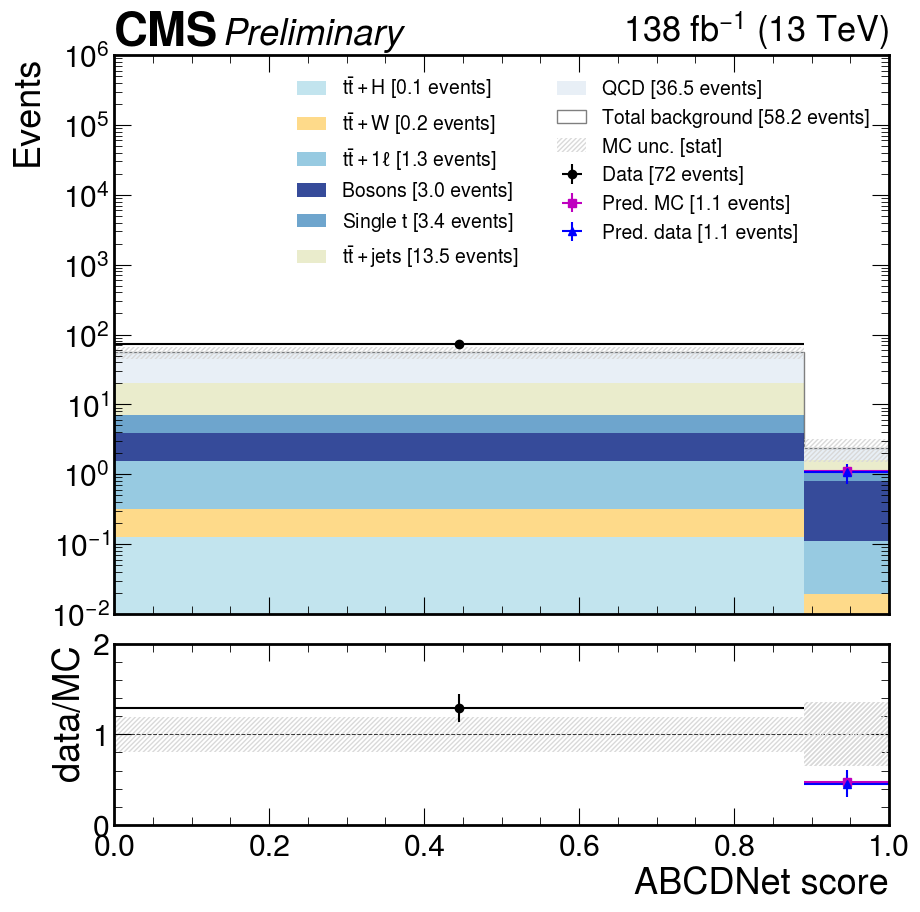

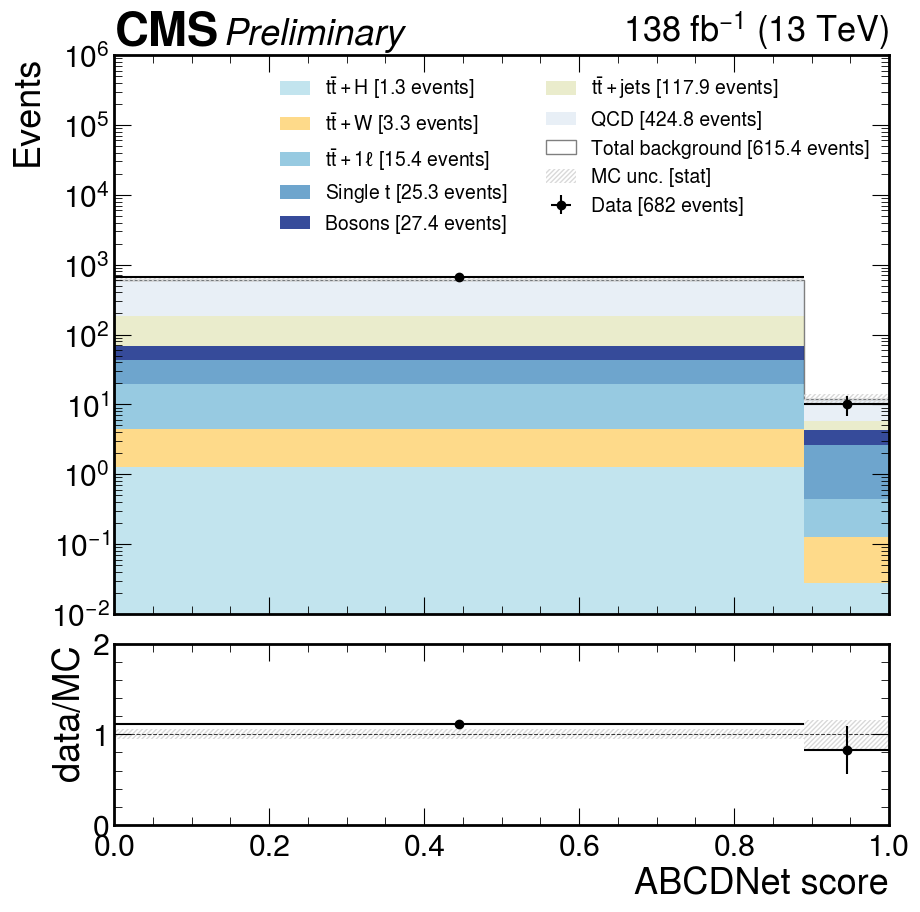

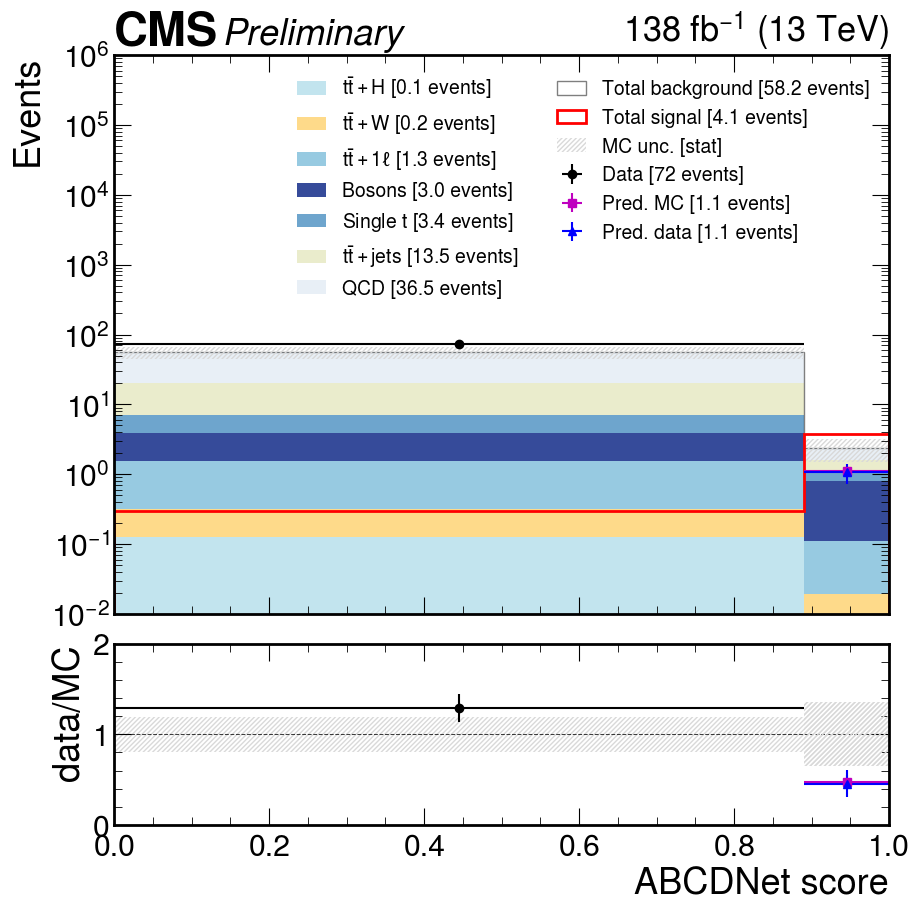

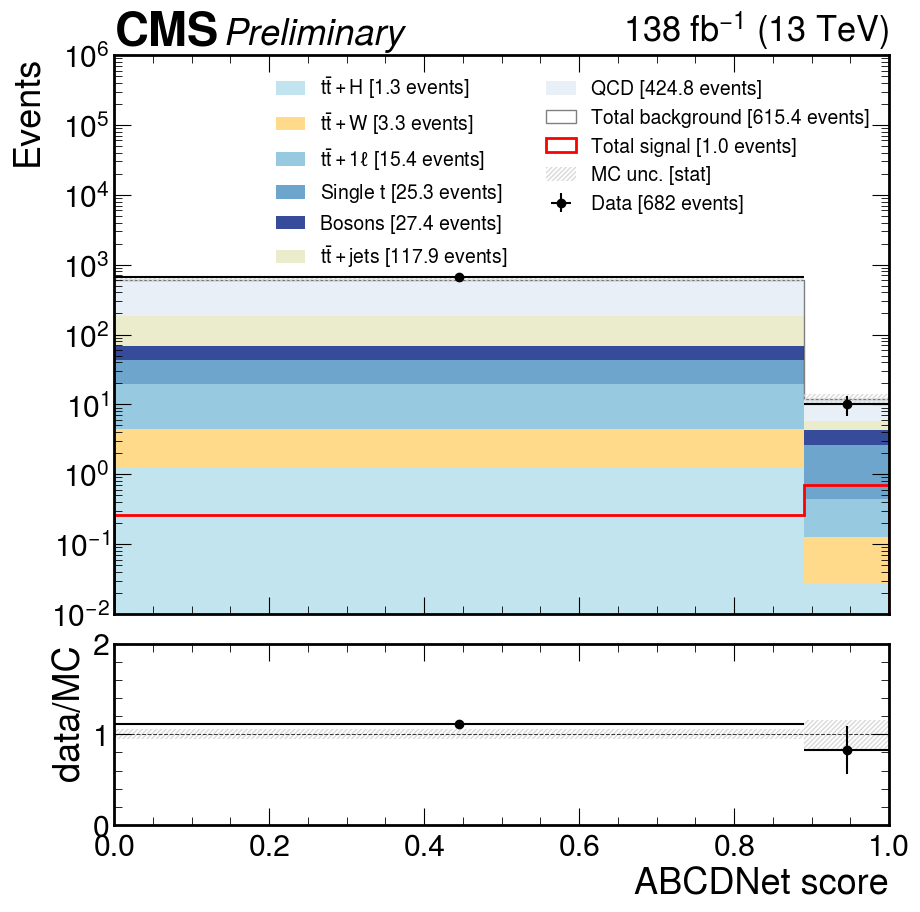

In [11]:
column = "abcdnet_score"
bins = [0, 0.89, 1.0]
x_label = r"ABCDNet score"
for sig_scale in [0, 1]:

    DtoC = vbsvvh.data_count(selection="regionC")/vbsvvh.data_count(selection="regionD")
    DtoC_mc = vbsvvh.bkg_count(selection="regionC")/vbsvvh.bkg_count(selection="regionD")


    hist_axes, ratio_axes = vbsvvh.plot_data_vs_mc(
        column, 
        bins=bins, 
        selection=f"(regionA or regionC)",
        x_label=x_label,
        stacked=True,
        blinded_range=(0.89, 1),
        blinded_box=False,
        autoblind=False,
        sig_scale=sig_scale
    )

    # Get numerator (data) and denominator (bkg MC)
    denom_df = vbsvvh.bkg_df(selection="regionA")
    denom = yahist.Hist1D(
        denom_df[column],
        bins=bins,
        weights=denom_df.event_weight,
    );
    numer_df = vbsvvh.data_df(selection="regionB")
    numer = yahist.Hist1D(
        numer_df[column],
        bins=bins,
        weights=numer_df.event_weight*DtoC,
        label=f"Pred. data [{len(numer_df)*DtoC:.1f} events]",
        color="b"
    );
    numer_mc_df = vbsvvh.bkg_df(selection="regionB")
    numer_mc = yahist.Hist1D(
        numer_mc_df[column],
        bins=bins,
        weights=numer_mc_df.event_weight*DtoC_mc,
        label=f"Pred. MC [{np.sum(numer_mc_df.event_weight)*DtoC_mc:.1f} events]",
        color="m"
    );

    # Get ratio
    ratio = numer/denom
    # Set ratio errors to data relative stat error times the ratio
    numer_counts = numer.counts
    numer_counts[numer_counts == 0] = 1e-12
    ratio._errors = (numer.errors/numer_counts)*ratio.counts

    # Get ratio
    ratio_mc = numer_mc/denom
    # Set ratio errors to data relative stat error times the ratio
    numer_mc_counts = numer_mc.counts
    numer_mc_counts[numer_mc_counts == 0] = 1e-12
    ratio_mc._errors = (numer_mc.errors/numer_mc_counts)*ratio_mc.counts

    # Plot hists and ratio
    numer_mc.plot(ax=hist_axes, errors=True, fmt="s")
    ratio_mc.plot(ax=ratio_axes, errors=True, fmt="s")
    numer.plot(ax=hist_axes, errors=True, fmt="^")
    ratio.plot(ax=ratio_axes, errors=True, fmt="^")

    # Plot MC relative stat error on unity; this makes no sense, but is LHC common practice
    denom_counts = denom.counts
    denom_counts[denom_counts == 0] = 1e-12
    err_points = np.repeat(denom.edges, 2)[1:-1]
    err_high = np.repeat(1 + denom.errors/denom_counts, 2)
    err_low = np.repeat(1 - denom.errors/denom_counts, 2)
    ratio_axes.fill_between(
        err_points, err_high, err_low,
        step="mid",
        hatch="///////",
        facecolor="none",
        edgecolor=(0.85, 0.85, 0.85),
        linewidth=0.0,
        linestyle="-",
        zorder=2
    )

    hist_axes.legend(fontsize=14, ncol=2)

    ratio_axes.set_ylim([0., 2.0])
    ratio_axes.legend().remove()

    hist_axes.set_yscale("log")
    hist_axes.autoscale()
    hist_axes.margins(x=0)
    hist_axes.set_ylim(bottom=1e-2, top=1e6)
    if sig_scale == 0:
        plt.savefig(f"{PLOTSDIR}/regionsAC_closure.pdf")
    else:
        plt.savefig(f"{PLOTSDIR}/regionsAC_closure_signal.pdf")


    # bins = [
    #     0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
    #     0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.97, 1.0
    # ]
    hist_axes, ratio_axes = vbsvvh.plot_data_vs_mc(
        "abcdnet_score", 
        bins=bins, 
        selection="(regionB or regionD)",
        x_label=r"ABCDNet score",
        stacked=True,
        autoblind=False,
        logy=True,
        sig_scale=sig_scale
    )
    ratio_axes.set_ylim([0., 2.0]);
    hist_axes.set_ylim(bottom=1e-2, top=1e6)
    hist_axes.legend(fontsize=14, ncol=2);
    if sig_scale == 0:
        plt.savefig(f"{PLOTSDIR}/regionsBD_closure.pdf")
    else:
        plt.savefig(f"{PLOTSDIR}/regionsBD_closure_signal.pdf")

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet_v3/val/abcdnet_score_data_vs_mc_log_presel.pdf


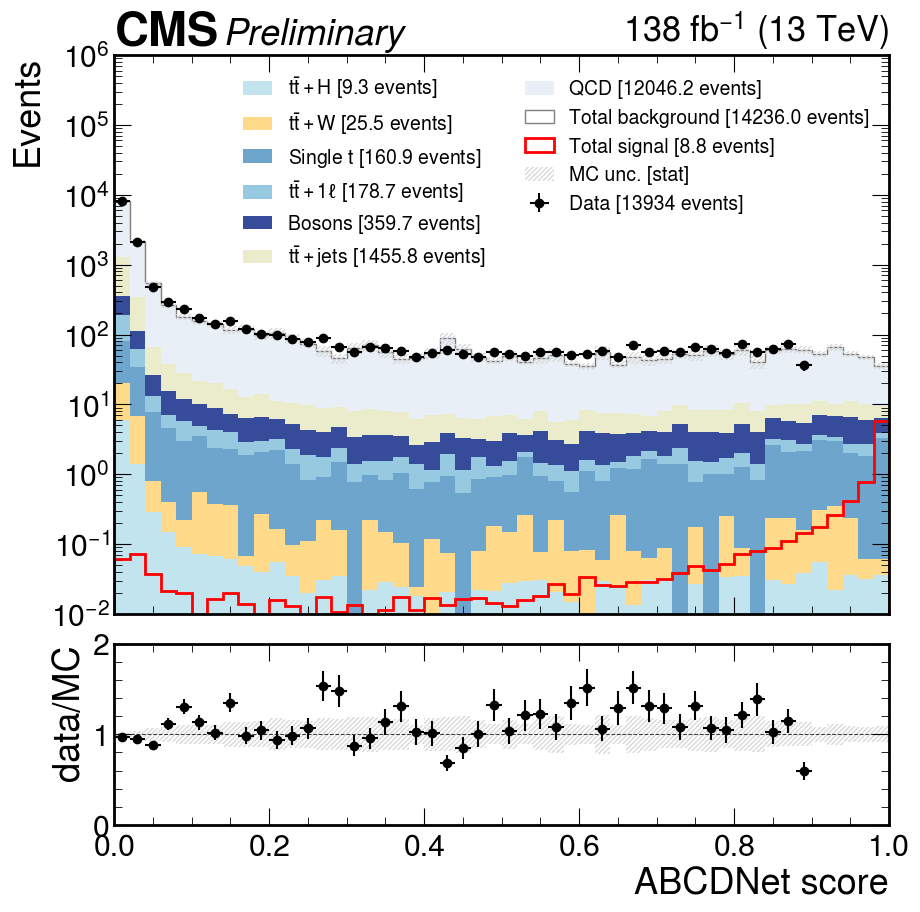

In [12]:
bins = np.linspace(0, 1, 51)
hist_axes, ratio_axes = vbsvvh.plot_data_vs_mc(
    "abcdnet_score", 
    bins=bins, 
    selection="presel",
    x_label=r"ABCDNet score",
    stacked=True,
    autoblind=True,
    blinded_range=[0.89, 1],
    blinded_box=False,
    logy=True,
    sig_scale=1
)
hist_axes.legend(fontsize=14, ncol=2)
ratio_axes.set_ylim([0, 2]);
hist_axes.set_ylim(top=1e6, bottom=1e-2);

plt.savefig(f"{PLOTSDIR}/abcdnet_score_data_vs_mc_log_presel.pdf")